# Classifying Job Descriptions: MBA vs Data Scientist

# Introduction

As technology permeates through industry, the rise of Data Science and Machine Llearning has led to many breakthroughs, innovations and discoveries as to how companies can shape and execute business strategy.  

The data scientist has thus become an indespensible part of the business.  Contrast this meteoric rise to that of a more traditional business leader, the MBA.  While these individuals are skilled at specific aspects of running a business such as Management, Marketing, Operations or Finance, there exists an ever-growing opportunity to enhance and empower such business expertise with scientifically-backed data analysis and tools.

We have entered a time where the gulf between science and business management is becoming ever smaller.  Companies need decisive leaders backed by a technical rigor and an innovative spirit.  Ergo, we need both MBAs and Data Scientists to lead our companies in 2017 and beyond.  

### Objective

In this analysis, we will explore the similarities and differences between the roles of MBA and Data Scientist as revealed through a comprehensive look at current trends in the job markets as well as the underlying job description text for both roles.

We will also develop, test and tweak machine learning models with the aim of accurately classifying job postings as either MBA or Data Science based on the text of the given descriptions.

We will accomplish these two objectives via sequential steps outlined below.
* Visualizing and tabulating the types of companies, cities and job titles represented by each job category
* Training various classification models to determine the job category by job description
* Exploring the classifications of the best model and digging deeper into the types of jobs that are hardest to classify.

##### What is the Ultimate Goal in this analysis?
The **Technical Objective** is to demonstrate the use of powerful Python packages like Pandas and Scikit-Learn to explore and deploy sophisticated machine learning models for accurate classification based on **Natural Language Processing (NLP)** of the job description texts.




**However...**




The **Overall Goal** is to find types of jobs that highlight career opportunities for people who are interested in both **Business** and **Data Science**.  What better way to accomplish this task than by leveraging data science and machine learning techniques to analyze a market: the job market!

As a professional with both an MBA and an interest in Data Science, I want to find jobs that appear to fit into either category.  Jobs that fall into this "niche" between the two categories are interesting because they might allow me to leverage my skills and pursue my interests in broader ways than the typical MBA type of position would.

The same types of jobs could, of course, appeal to Data Scientists who want to become more active on the business side of things.

Potential parties who might include might benefit from this analysis:
* MBAs interested in pursuing roles related to Data Science.
* Data Scienstists interested in purusing roles related to Business Management and Administration.
* Managers seeking employees who fill the requirements of either (or both) role categories.

In [1]:
import sys
import pandas as pd
pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_rows', 500)
pd.options.mode.chained_assignment = None

import nltk
import numpy as np
import re
import sklearn
import matplotlib
import geopy
import scipy
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

### Data Source: Indeed.com

Job description data was collected from [www.Indeed.com](www.Indeed.com) for most of the large cities in the United States.  For collection purposes, Indeed's Job Search API was utilized over a period of several months in Summer of 2017.  

The API was given two queries to run each day where the job criteria to seach for one was "MBA" and "Data Science" for another.  The Queries were set to search in the same ___WIP___ cities.

A notebook outlining the methogology and code for collecting and storing the data on a daily basis can be found here ___WIP__ for those who are interested.

Once we import the data and group by job category ("MBA" & "Data Science"), we see we that our dataset has 50K jobs from each category.

In [2]:
df_combined = pd.read_csv("https://raw.githubusercontent.com/CollierKing/Classify_Jobs_Indeed/master/indeed_jobs.csv",encoding = "utf-8")
df_combined.groupby('category').size()

category
data_science    50000
mba             50000
dtype: int64

Lets take a quick glance at the data. We have several columns of interest such as Job Location, Company, Job Title and 'Snippet.' Snippet is a text field with the description for the particular job.

In [245]:
df_combined.head(2)

,Unnamed: 0,Unnamed: 0.1,Location,Company,Date,Job_Key,Job_Title,Snippet,category,degree
0,0,23374,"New York, NY",KIND,2017-08-09,173c07f47196c8fd,"Analyst, Strategic Sourcing",lead collection analysis spend data develop commodity category strategies create formula based cost models understand industry cost structures individual work collaboratively cross functional partners r amp operations quality manufacturing finance defined ingredient categories sub categories support develop long term category strategies ;D,data_science,
1,1,13349,"Milwaukee, WI",ShoreTel,2017-07-17,b9be2d7ef701e6e5,Software Development Engineer,position drive features revolutionize way enterprise employees use phones office networks bachelorâ degree computer management information systems code test debug programs outlined systemâ technical functional requirements analyze problems develop solutions,data_science,computer


Here is another look at a random job description in the dataset.

In [248]:
df_combined.loc[2222,"Snippet"]

'master degree computer engineering data analytics data finance related field design configure test deploy apptio dashboards reports underlying data models meet functional design specifications certified data management professional cdmp certification experience application relational database concepts completing technical design'

##### Time Trends

Looking at the cumulative sum of jobs that were posted in each category, we see that MBA jobs initially outpaced Data Science jobs, but during the month of August 2017, the number of Data Science jobs that were being posted began to spike.  

While this is an admittedly small sample size of jobs in a somewhat narrow window of time, watching the number of Data Science jobs posted overtake that of MBAs was interesting.

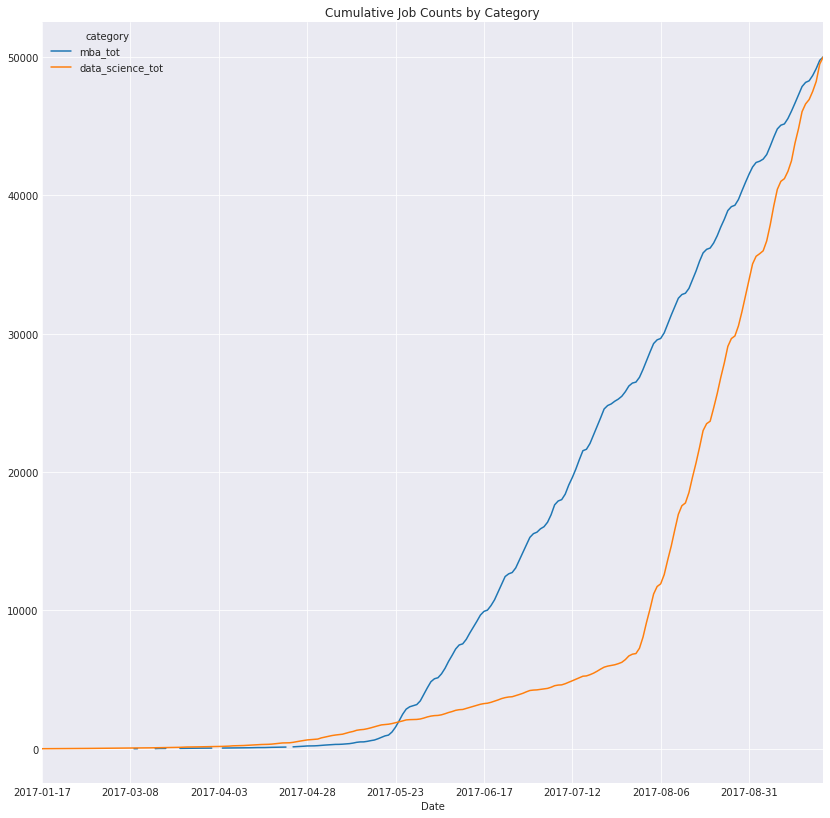

In [4]:
pivoted_counts = pd.pivot_table(df_combined, index=['Date'], 
                            columns='category', values='Job_Key',aggfunc="size")
pivoted_counts.reset_index(inplace=True)
pivoted_counts['data_science_tot'] = np.cumsum(pivoted_counts['data_science'])
pivoted_counts['mba_tot'] = np.cumsum(pivoted_counts['mba'])
pivoted_counts.index = pivoted_counts['Date']
pivoted_counts = pivoted_counts[['mba_tot','data_science_tot']]
% matplotlib inline
sns.set_style("darkgrid")
pivoted_counts.plot(figsize=(14,14),title="Cumulative Job Counts by Category");

# Pre-Analysis Prep

Before we go any further, we wil define some useful functions that will aggregate and plot various features for us.  Doing this upfront will save us a lot of time later.

### Plotting Functions

In [5]:
def make_tbl(width,height,df,title,df2,title2):
    import matplotlib.pyplot as plt
    from matplotlib import six
    from matplotlib import gridspec
    import seaborn as sns
    sns.set(font_scale=2)

    fig = plt.figure(figsize=(18,14))
    gs = gridspec.GridSpec(1, 2, width_ratios=[3, 3]) 
    ax1 = plt.subplot(gs[0])

    ax1.axis('off')
    # col_width=20.0
    # row_height=2
    font_size=10
    header_color='#40466e'
    row_colors=['#f1f1f2', 'w']
    edge_color='w'
    bbox=[0, 0, 1, 1]
    header_columns=0

    mpl_table = ax1.table(cellText = df.values, 
                          bbox=bbox, colLabels=df.columns)

    mpl_table.auto_set_font_size(False)
    mpl_table.set_fontsize(font_size)

    for k, cell in six.iteritems(mpl_table._cells):
        cell.set_edgecolor(edge_color)
        if k[0] == 0 or k[1] < header_columns:
            cell.set_text_props(weight='bold', color='w', wrap=True)
            cell.set_facecolor(header_color)
        else:
            cell.set_facecolor(row_colors[k[0]%len(row_colors) ])

    ax1.set_title(title);

    if df2:
        ax2 = plt.subplot(gs[1])

        ax2.axis('off')
        # col_width=20.0
        # row_height=2
        # font_size=10
        header_color='#40466e'
        row_colors=['#f1f1f2', 'w']
        edge_color='w'
        bbox=[0, 0, 1, 1]
        header_columns=0

        mpl_table = ax2.table(cellText = df2.values, 
                              bbox=bbox, colLabels=df2.columns)

        mpl_table.auto_set_font_size(False)
        mpl_table.set_fontsize(font_size)

        for k, cell in six.iteritems(mpl_table._cells):
            cell.set_edgecolor(edge_color)
            if k[0] == 0 or k[1] < header_columns:
                cell.set_text_props(weight='bold', color='w', wrap=True)
                cell.set_facecolor(header_color)
            else:
                cell.set_facecolor(row_colors[k[0]%len(row_colors) ])


        ax2.set_title(title2);


In [6]:
sns.set(style="ticks")

def make_plot_tbl(width,height,plot_size,
                     tbl_size,df,col):
    import matplotlib.pyplot as plt
    from matplotlib import six
    from matplotlib import gridspec
    import seaborn as sns
    import matplotlib.ticker as mtick
    fmt = '${x:,.0f}'
    fig = plt.figure(figsize=(width,height))
    gs = gridspec.GridSpec(1, 2, width_ratios=[plot_size, tbl_size]) 
    ax1 = plt.subplot(gs[0])
    current_palette_7 = sns.color_palette("Set1", 2)
    sns.set_palette(current_palette_7)
    sns.set(style="ticks")
    
    sns.barplot(x=df1.index, y=col, 
                data=df1, ax=ax1,
                linewidth=2.5,color='#40466e');
    
    sns.despine(left=True, bottom=True)
    ax1.set_title(title)
    ax1.set_xlabel(xlabel)
    ax1.set_ylabel(ylabel)
    tick = mtick.StrMethodFormatter(fmt)
    
    if yaxis_fmt:
        ax1.yaxis.set_major_formatter(tick) 
    if xaxis_fmt:
        ax1.xaxis.set_major_formatter(tick) 
        
    ax2 = plt.subplot(gs[1])
    ax2.axis('off')
    font_size=10
    header_color='#40466e'
    row_colors=['#f1f1f2', 'w']
    edge_color='w'
    bbox=[0, 0, 1, 1]
    header_columns=0
    
    mpl_table = ax2.table(cellText = df.values, rowLabels = df.index,
                      bbox=bbox, colLabels=df.columns)

        
    mpl_table.auto_set_font_size(False)
    mpl_table.set_fontsize(font_size)
    for k, cell in six.iteritems(mpl_table._cells):
        cell.set_edgecolor(edge_color)
        if k[0] == 0 or k[1] < header_columns:
            cell.set_text_props(weight='bold', color='w', wrap=True)
            cell.set_facecolor(header_color)
        else:
            cell.set_facecolor(row_colors[k[0]%len(row_colors) ])
    return gs;

### Cleaning Text

#### Job Descriptions

Now we will begin to look at the actual text in the job descriptions. This text will later become the classification features of our models. In order to not 'game' the classification process, we will remove some overly descriptive terms from the job descriptions, which might tip the algorithm as to the actual category its classifying.  These terms include "MBA", "Data Scientist" and like terms.

In [7]:
import re
def preprocessor(text):
    text = re.sub('<[^>]*>', '', text)
    emoticons = re.findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)', text)
    text = re.sub('[\W]+', ' ', text.lower()) +\
        ' '.join(emoticons).replace('-', '')
    test = re.sub("â",'',text)
    return text

import nltk
# nltk.download('stopwords')
from nltk.corpus import stopwords
stop = stopwords.words('english')

In [8]:
# add custom stopwords
stop_plus = ["mba",
             "m.b.a",
             "masters of business administration",
             "masters in business administration",
             "masters business administration",
             "master business administration",
             "data scientist","data science",
             "science"]
# combine stopword lists
stop = stop + stop_plus

In [9]:
df_combined_clean = df_combined
df_combined_clean['Snippet'] = df_combined_clean['Snippet'].apply(preprocessor)
df_combined_clean['Snippet'] = df_combined_clean['Snippet'].apply(lambda x: [item for item in str.split(x) if item not in stop])
df_combined_clean['Snippet'] = df_combined_clean['Snippet'].apply(lambda x: ' '.join(x))
df_combined_clean['Snippet'] = df_combined_clean['Snippet'].str.replace("mba","")
df_combined_clean['Snippet'] = df_combined_clean['Snippet'].str.replace("m.b.a.","")
df_combined_clean['Snippet'] = df_combined_clean['Snippet'].str.replace("data science","")
df_combined_clean['Snippet'] = df_combined_clean['Snippet'].str.replace("datascience","")
df_combined_clean['Snippet'] = df_combined_clean['Snippet'].str.replace("data scientist","")
df_combined_clean['Snippet'] = df_combined_clean['Snippet'].str.replace("masters business administration","")
df_combined_clean['Snippet'] = df_combined_clean['Snippet'].str.replace("master business administration","")

#### Job Titles

Aside from the text in the job descriptions themselves, we could also benefit from some slightly cleaner job titles.

Many job titles are listed with a "Senior" or "Sr." prefix.  This is a bit unecessary as the differences between a Senior Analyst and an Analyst are a bit acute for our needs.  Let's remove these seniority prefixes so as not to duplicate the same type of job title.

In [10]:
df_combined_clean['Job_Title'] = df_combined_clean['Job_Title'].astype(str)
df_combined_clean['Job_Title'] = df_combined_clean['Job_Title'].str.replace("Sr ","")
df_combined_clean['Job_Title'] = df_combined_clean['Job_Title'].str.replace("Sr. ","")
df_combined_clean['Job_Title'] = df_combined_clean['Job_Title'].str.replace("Senior ","")
df_combined_clean['Job_Title'] = df_combined_clean['Job_Title'].str.replace("senior ","")
df_combined_clean['Job_Title'] = df_combined_clean['Job_Title'].str.replace("sr ","")
df_combined_clean['Job_Title'] = df_combined_clean['Job_Title'].str.replace("sr. ","")

In [11]:
df_data_sci_clean = df_combined_clean[df_combined_clean['category']=="data_science"]
df_mba_clean = df_combined_clean[df_combined_clean['category']=="mba"]

### Tokenizing Text

In order to make the text from our job descriptions into useful model features, we have to aggregate and summarise distinct terms in a meaningful way.  To accomplish this, we will transform our job description data into a **Term Frequency–Inverse Document Frequency (TF-IDF)** matrix.  

TF-IDF is a popular word weighting scheme which seeks to define how important a word is to a document in a collection or corpus. Under TF-IDF, words that occur frequently within a given document (or job description in our case), but do not occur frequently within the entire corpos of words, will receive a larger weighting as they are deamed to be more important in relaying meaning behind the given document. 

You can read more about the TF-IDF methogology and structure in scikit-learn [here:](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html).

# Exploratory Data Analysis

In the following section we will explore the data by looking at the geographical distribution of jobs as well as the types of jobs in companies and cities.  We will group and summarise the data into meaningful tables and visualations with Pandas and Seaborn. We will also utilize some unsupervised learning techniques to uncover more about the relationships in our text data.

### Unsupervised Techniques

#### K-means Clustering

**K-means** is a popular algorithm for clustering.  **Clustering** is a technique that allows us to uncover groups of related data points as defined by being more similar to each other than they are to other data points. The metric we use for 'similarity' is actually the level of distance between two points, specifically the **squared Euclidean distance**.

The K-means algorithm is essentially an optimization solver, which interates over the data and creates **centroids** which are the average of similar points within a given cluster.  The goal is to minimize the **within-cluster sum of squared errors (SSE)** or **"distortion"** of the data points within the cluster. This is accomplished after the either the specified number of iterations is passed or convergence is reached.

In this analysis, we will fit the clusters based on the text of the job descriptions and then visualize the clusters across different categories such as city, company and job title.

You can read more about K-means [here](https://en.wikipedia.org/wiki/K-means_clustering).

#### Multi-Dimensional Scaling

**Multi-Dimensional Scaling (MDS)** is a non-linear dimensionality reduction algorithm.  It is often used to visualize levels of similarity or disparity among observations in a dataset.  This is useful when dealing with high dimensional data (such as the text data in our sample) as we can condense the dimensions into 2, into a visual plane.  Other similar dimensionality reduction techniques include **Principal Component Analysis (PCA)** and **Factor Analysis**.

You can read more about MDS [here](https://en.wikipedia.org/wiki/Multidimensional_scaling).

### Top Skill Keywords

One topic of great interest in this analysis is what the distribution of skill-specific keywords looks like across different categories.  We will investigate the number of skill keywords across locations, companies and job titles later, but now let's take a look at the overall picture across our two job categories.

To determine what skill-specific key words to look for, we turn to top tag lists [www.stackexchange.com](www.stackexchange.com), maintainer of [www.stackoverflow.com](www.stackoverflow.com) and a popular source for skill-specific questions and conversations. The notebook containing the query used for this purpose can be found [here](https://github.com/CollierKing/stackexchange_keywords).

To obtain skill keywords specific to both MBA and Data Science, we took the top tags from the following domain-specific sites from StackExchange:
* Economics: https://economics.stackexchange.com/
* AI: https://ai.stackexchange.com/
* Product Management: https://pm.stackexchange.com/
* Quantitative Finance: https://quant.stackexchange.com/
* Startups: https://startups.stackexchange.com/
* Computer Science: https://cs.stackexchange.com/
* Statistics: https://stats.stackexchange.com/

We also pulled the top listed tags from stackoverflow [here](https://data.stackexchange.com/stackoverflow/csv/903268).

We have a collection just over 50K skill words, however we are only going to use the top 250 as beyond that we start to get into some very niche technical terminology which is not broadly applicable to our analysis.

In [177]:
keywords = pd.read_csv("https://raw.githubusercontent.com/CollierKing/stackexchange_keywords/master/stack_exchange_keywords.csv",header=None)
keywords.columns = ["index","keywords"]
keywords.drop_duplicates(subset="keywords",keep="last",inplace=True)
keywords.reset_index(inplace=True)
del keywords["index"]
del keywords["level_0"]
keywords["cat_count"] = ""
keywords["loc_count"] = ""
keywords["company_count"] = ""
keywords["jobtitle_count"] = ""
keywords = keywords.head(250)

for idx,word in keywords.iterrows():
    if idx > 250:
        continue
    else:
        try:
            sub = df_combined_clean[df_combined_clean['Snippet'].str.contains(word[0],na=False)]
            cat_list = dict(sub.groupby("category").size())
            loc_list = dict(sub.groupby("Location").size())
            company_list = dict(sub.groupby("Company").size())
            jobtitle_list = dict(sub.groupby("Job_Title").size())

            keywords.set_value(idx,"cat_count",cat_list)
            keywords.set_value(idx,"loc_count",loc_list)
            keywords.set_value(idx,"company_count",company_list)
            keywords.set_value(idx,"jobtitle_count",jobtitle_list)
        except:
            continue
#     if idx % 50 == 0:
#         print(idx/len(keywords))

In [202]:
for idx, word in keywords.iterrows():
    test = word["cat_count"]
    if "mba" in test or "data" in test:
        keys = list(test.keys())
        vals = list(test.values())
        df = pd.DataFrame({"keys":keys,"vals":vals},columns=["keys","vals"])
        df["word"] = word[0]
        if idx == 0:
            df_all = df
        else:
            df_all = pd.concat([df_all,df])
            
data_science_keywords = df_all[df_all['keys']=="data_science"]
mba_keywords = df_all[df_all['keys']=="mba"]
data_science_keywords.sort_values(by="vals",ascending=False,inplace=True)
mba_keywords.sort_values(by="vals",ascending=False,inplace=True)
data_science_keywords = data_science_keywords[~\
                  data_science_keywords['word'].isin(["c","nt","ant","ide","com","gis",
                        "design","format","tools","training",
                         "idea","forms","collaboration",
                         "partnership","air","provider",
                         " net","git","career","trust"])]
mba_keywords = mba_keywords[~\
                mba_keywords['word'].isin(["c","nt","ant","ide","com","gis",
                        "design","format","tools","training",
                         "idea","forms","collaboration",
                         "partnership","air","provider",
                         " net","git","career","trust"])]

Lets take a look at the top skill keywords by job category.

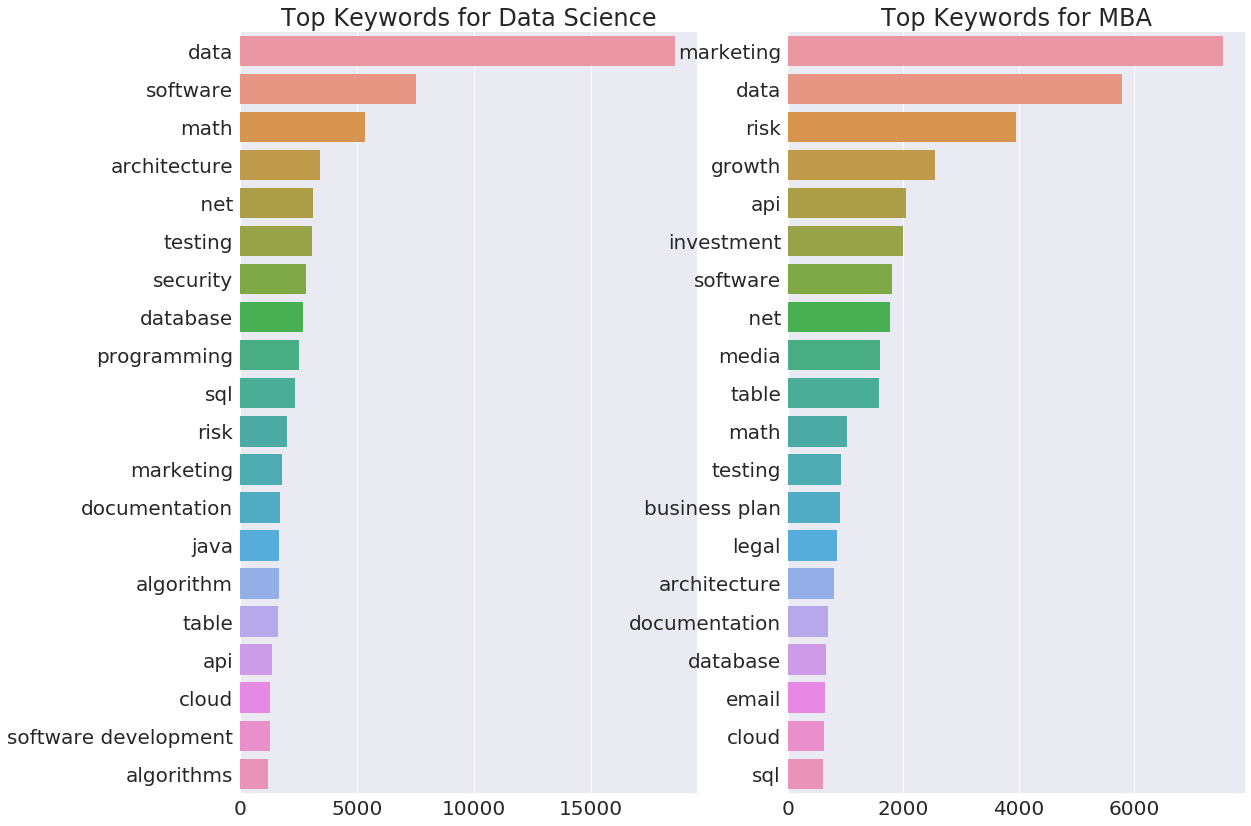

In [203]:
import matplotlib.pyplot as plt
from matplotlib import six
from matplotlib import gridspec
import seaborn as sns
sns.set(font_scale=2)

fig = plt.figure(figsize=(18,14))
gs = gridspec.GridSpec(1, 2, width_ratios=[3, 3]) 
ax1 = plt.subplot(gs[0])

sns.barplot(y='word', x='vals', 
            data=data_science_keywords.head(20), ax=ax1,linewidth=2.5);
ax1.set_title("Top Keywords for Data Science")
ax1.set_ylabel("")
ax1.set_xlabel("")

ax2 = plt.subplot(gs[1])
            
sns.barplot(y='word', x='vals', 
            data=mba_keywords.head(20), ax=ax2,linewidth=2.5);

ax2.set_ylabel("")
ax2.set_xlabel("")

ax2.set_title("Top Keywords for MBA");

#### Data Science

Looking at the top skill keywords for Data Science, we see a lot of software and coding terms like "architecture", "database" and "linux".  We also see some business terms popping up like "econometrics","risk" and "marketing".

In [15]:
ds_kw_ranks = pd.DataFrame(np.arange(180).reshape(18, 10))
ds_kw_ranks = ds_kw_ranks.astype(str)
ds_kw_ranks.index = np.arange(1, len(ds_kw_ranks) + 1)
ds_kw_ranks.columns = np.arange(1, (ds_kw_ranks.shape[1]) + 1)
data_science_keywords.index = np.arange(1, len(data_science_keywords) + 1)

colnum = 0
for col in ds_kw_ranks:
    colnum = colnum + 1
    try:
        for idx, row in ds_kw_ranks.iterrows():
            if col == 1:
                ds_kw_ranks.set_value(idx,col,
                     data_science_keywords.loc[colnum*idx,"word"])
            else:
                ds_kw_ranks.set_value(idx,col,
                     data_science_keywords.loc[(colnum*18)+idx,"word"])
    except:
        continue

ds_kw_ranks

,1,2,3,4,5,6,7,8,9,10
1,data,provider,migration,funding,postgresql,returns,csv,taxation,hdd,9
2,design,javascript,investment,scrum master,estimating,portfolio management,data request,reflection,inflation,19
3,tools,growth,flex,business plan,music,tech company,youtube,international trade,28,29
4,format,sql server,legal,printing,mobile apps,peripherals,futures,puzzle,38,39
5,software,oracle,embed,memory,delphi,versioning,compression,monte carlo,48,49
6,math,collaboration,embedded,registry,navigation,xslt,fx,interest rates,58,59
7,architecture,windows,xml,legacy,sorting,equities,interest rate,taxes,68,69
8,net,career,theory,authentication,fixed income,resource planning,derivatives,sockets,78,79
9,testing,unix,web development,clustering,encryption,distributions,self study,pm software,88,89
10,security,html,directory,equity,convention,vb net,tutorials,intelligent agent,98,99


#### MBA

Looking at the top skill keywords for MBAs, we see terms relating to risk, marketing, prohect management and finance.  Interestingly we also see some more technical terms related to software and data science like "logistic" and "python".

In [16]:
mba_kw_ranks = pd.DataFrame(np.arange(180).reshape(18, 10))
mba_kw_ranks = mba_kw_ranks.astype(str)
mba_kw_ranks.index = np.arange(1, len(mba_kw_ranks) + 1)
mba_kw_ranks.columns = np.arange(1, (mba_kw_ranks.shape[1]) + 1)
mba_keywords.index = np.arange(1, len(mba_keywords) + 1)

colnum = 0
for col in mba_kw_ranks:
    colnum = colnum + 1
    try:
        for idx, row in mba_kw_ranks.iterrows():
            if col == 1:
                mba_kw_ranks.set_value(idx,col,
                     mba_keywords.loc[colnum*idx,"word"])
            else:
                mba_kw_ranks.set_value(idx,col,
                     mba_keywords.loc[(colnum*18)+idx,"word"])
    except:
        continue

mba_kw_ranks

,1,2,3,4,5,6,7,8,9,10
1,design,market research,membership,taxation,convention,linq,iphone,pdf,string,9
2,marketing,logistic,intellectual property,embedded,javascript,sorting,reflection,hdd,vb net,19
3,tools,programming,python,distributions,international trade,customer development,random,tags,eclipse,29
4,data,hardware,estimating,derivatives,registry,unix,option pricing,passwords,csv,39
5,risk,tasks,embed,econometrics,beta,iteration,pm software,sockets,puzzle,49
6,format,flex,equities,interest rate,tutorials,data request,natural language,arrays,versioning,59
7,growth,fixed income,fx,css,photoshop,iis,production function,db2,self study,69
8,training,project team,taxes,algorithms,browser,directory,globalization,lean startup,78,79
9,api,oracle,theory,sql server,navigation,peripherals,encryption,economic growth,88,89
10,investment,funding,market data,resource planning,authentication,apache,neural networks,self learning,98,99


### Top Academic Degrees

Next we will examine the different types of educational requirements for positions in each category. For this part, we will ignore the obvious fact that MBA jobs most likely require an MBA and look for any type of degree listed in the job description.

I am not an expert with regular expressions, but I have fashioned a function which will search for a given key word and extract the immediate word that follows it.  In this case we will search for the word "degree" and extract the first word that follows.

We return some garbage words like "accredited" and "required" which we dispense with.  The below table shows the top twenty degrees words in each category.

A couple of takeaways here:
* Data Science jobs require "computer science" degrees by far and away more than any other degree.

* MBA jobs are dominated by "business", "accounting" and "finance" degrees, but "computer" and "engineering" degrees are in the top five.  Both degrees have a suprising amount of overlapping engineering and science degrees suggesting that the gap between the two professions might not be so wide after all.

In [286]:
def substring_after(s, delim):
    text1 = s.partition(delim)[2]
    text2 = text1.partition(" ")[0]
    return text2

In [18]:
df_combined_clean["degree"] = ""
for idx, row in df_combined_clean.iterrows():
    degree_val = substring_after(row['Snippet'],"degree ")
    df_combined_clean.set_value(idx,"degree",degree_val)

In [19]:
degree_stopwords = ["required","related","preferred","accredited","equivalent",
    "preferably","relevant","higher","plus","find","field",
    "youâ","","program","major"]

df_combined_clean2 = df_combined_clean[~df_combined_clean['degree'].isin(degree_stopwords)]

degrees_mba = pd.DataFrame(df_combined_clean2[\
                          df_combined_clean2['category']=="mba"].groupby("degree").size().sort_values(ascending=False))

degrees_mba.reset_index(inplace=True)
degrees_mba.columns = ["MBA","count"]

degrees_ds = pd.DataFrame(df_combined_clean2[\
                          df_combined_clean2['category']=="data_science"].groupby("degree").size().sort_values(ascending=False))


degrees_ds.reset_index(inplace=True)
degrees_ds.columns = ["Data Science","count"]

In [20]:
pd.concat([degrees_ds,degrees_mba],axis=1).head(20)

,Data Science,count,MBA,count
0,computer,7903,business,2145.0
1,engineering,903,accounting,1370.0
2,business,716,finance,861.0
3,information,380,computer,804.0
4,electrical,345,engineering,801.0
5,technical,290,marketing,539.0
6,quantitative,234,technical,491.0
7,statistics,227,quantitative,168.0
8,mathematics,194,supply,117.0
9,life,188,electrical,84.0


### Top Certifications

https://en.wikipedia.org/wiki/List_of_professional_designations_in_the_United_States

In [287]:
df_combined_clean["cert"] = ""
for idx, row in df_combined_clean.iterrows():
    degree_val = substring_after(row['Snippet'],"certified ")
    df_combined_clean.set_value(idx,"cert",degree_val)

In [292]:
# df_combined_clean['cert'].value_counts()

In [308]:
df_combined_clean[df_combined_clean['Snippet'].str.contains("crma")].shape

(10, 11)

### Job Locations

Jobs from a wide variety of employment locations were obtained in the data collection process. Lets visualize the distribution of location of jobs geographically. We pulled the latitude/longitude coordinates of each city and then plot them on a map of the U.S. The notebook containing the code with this query is here["https://github.com/CollierKing/city_geolocator] WIP

In [21]:
city_list = pd.read_csv("https://raw.githubusercontent.com/CollierKing/city_geolocator/master/city_list.csv")

We will also calculate the relative prevalence of either MBA or Data Science jobs in a given location.  This will be calculated as a ratio of the numer of Data Science jobs to total jobs.  Below is a glance at the city dataframe.

In [22]:
# calculate ratios of data science to total jobs by city
city_list_ratio = pd.DataFrame(df_combined
                               .groupby(['Location','category'])
                               .size()).reset_index().sort_values(0,ascending=False)
city_list_ratio = city_list_ratio.pivot(index='Location', columns='category', values=0).reset_index()
city_list_ratio['DS_%'] = city_list_ratio['data_science']/(city_list_ratio['data_science']+\
                                                              city_list_ratio['mba'])
city_list_ratio['City'] = city_list_ratio['Location']
# city_list_ratio.sort_values('DS_ratio',ascending=False)
city_list2 = city_list.merge(city_list_ratio,how="inner",on="City")
city_list2['DS_%'] = city_list2['DS_%'].fillna(0)
city_list2['DS_%'] = round(city_list2['DS_%'],3)
city_list2['total'] = city_list2['data_science']+city_list2['mba']
city_list2.sort_values("total",ascending=False,inplace=True)
city_list2 = city_list2.head(500)
city_list2.sort_values("total",ascending=True,inplace=True)
city_list2.reset_index(inplace=True)

#### Geographic Distribution of Jobs

Lets plot the locations of the top 500 cities in our dataset as determined by total jobs. <span style="color:blue"> Blue </span> shapes represent cities with more than 60% of the posted jobs belonging to the data science category while <span style="color:red"> Red </span> shapes represent towns with more than 60% jobs as MBA.  Towns where between 40-60% of jobs are in either category are colored <span style="color:purple"> Purple </span>.  The map is interactive, so the user can scroll over the country and click on different cities.  A total job count figure is given by clicking on a marker, as well as the percentage of that city's jobs that are Data Science jobs.

In [459]:
import folium
#create map of united states
map_osm = folium.Map(location=[39.50,-98.35], zoom_start=5)

In [460]:
#loop through city coordinates and plot city points
for idx, point in city_list2.iterrows():
    if idx > 500:
        break
    else:
        x = float(point['lon'])
        y = float(point['lat'])

        if point['DS_%'] >= 0.0 and point['DS_%'] < 0.4:
            folium.RegularPolygonMarker([x,y], popup=str(point['City'])+": DS %: "+str(round(point['DS_%']*100,3))+"%, Job Count: "+str(point['total']),
                          fill_color='red',number_of_sides=6,radius=10).add_to(map_osm)

        elif point['DS_%'] >= 0.4 and point['DS_%'] < 0.6:
            folium.RegularPolygonMarker([x,y], popup=str(point['City'])+": DS %: "+str(round(point['DS_%']*100,3))+"%, Job Count: "+str(point['total']),
                          fill_color='purple',number_of_sides=6,radius=10).add_to(map_osm)

        elif point['DS_%'] >= 0.6 and point['DS_%'] <= 1:
            folium.RegularPolygonMarker([x,y], popup=str(point['City'])+": DS %: "+str(round(point['DS_%']*100,3))+"%, Job Count: "+str(point['total']),
                          fill_color='blue',number_of_sides=6,radius=10).add_to(map_osm)

In [461]:
map_osm

#### Top Locations by Category

If we take a look at jobs across job categories and locations, we see that New York, Chicago, San Francisco and Seattle are the top spots for both Data Science and MBA jobs in terms of the number of raw postings.  

In [23]:
ds_job_locs = pd.DataFrame((df_data_sci_clean
     .groupby('Location')
     .count()
     .sort_values('Company',ascending=False)['Company']
     .reset_index()))
mba_job_locs = pd.DataFrame((df_mba_clean
     .groupby('Location')
     .count()
     .sort_values('Company',ascending=False)['Company']
     .reset_index()))
combined_locs = pd.concat([mba_job_locs, ds_job_locs], axis=1)
combined_locs.columns = ['MBA_Locations','Job_Counts',
                         'DS_Locations','Job_Counts']

In [24]:
combined_locs.head(20)

,MBA_Locations,Job_Counts,DS_Locations,Job_Counts
0,"New York, NY",5031.0,"New York, NY",2895
1,"Chicago, IL",2606.0,"San Francisco, CA",2355
2,"San Francisco, CA",2542.0,"Chicago, IL",1824
3,"Seattle, WA",2274.0,"Seattle, WA",1734
4,"Boston, MA",1508.0,"Atlanta, GA",1321
5,"Los Angeles, CA",1470.0,"Boston, MA",1256
6,"Houston, TX",1465.0,"San Diego, CA",1142
7,"Atlanta, GA",1281.0,"Austin, TX",1131
8,"Washington, DC",1002.0,"Houston, TX",1071
9,"Austin, TX",971.0,"Washington, DC",1050


#### Top Location Category Ratios

Among our top locations, San Fancisco, Atlanta and Washington D.C. have some of the most even ratios of MBA to Data Science jobs.

In [25]:
city_list_ratio = pd.DataFrame(df_combined
                               .groupby(['Location','category'])
                               .size()).reset_index().sort_values(0,ascending=False)
city_list_totals = city_list_ratio.groupby("Location").agg({0:np.sum})
city_list_totals['Location'] = city_list_totals.index
city_list_ratio = city_list_ratio.merge(city_list_totals,how="inner",on="Location")
city_list_ratio.columns = ["Location","category","cat_count","tot_count"]
city_list_ratio['cat_pct'] = city_list_ratio['cat_count']/city_list_ratio['tot_count']
city_list_ratio = city_list_ratio.sort_values(['tot_count','Location','category'],ascending=False)
city_list_ratio = city_list_ratio.head(50)
df1 = pd.DataFrame(city_list_ratio.head(50))
df1['cat_pct'] = round(df1['cat_pct'],3)
# df1.index = df1['Location']

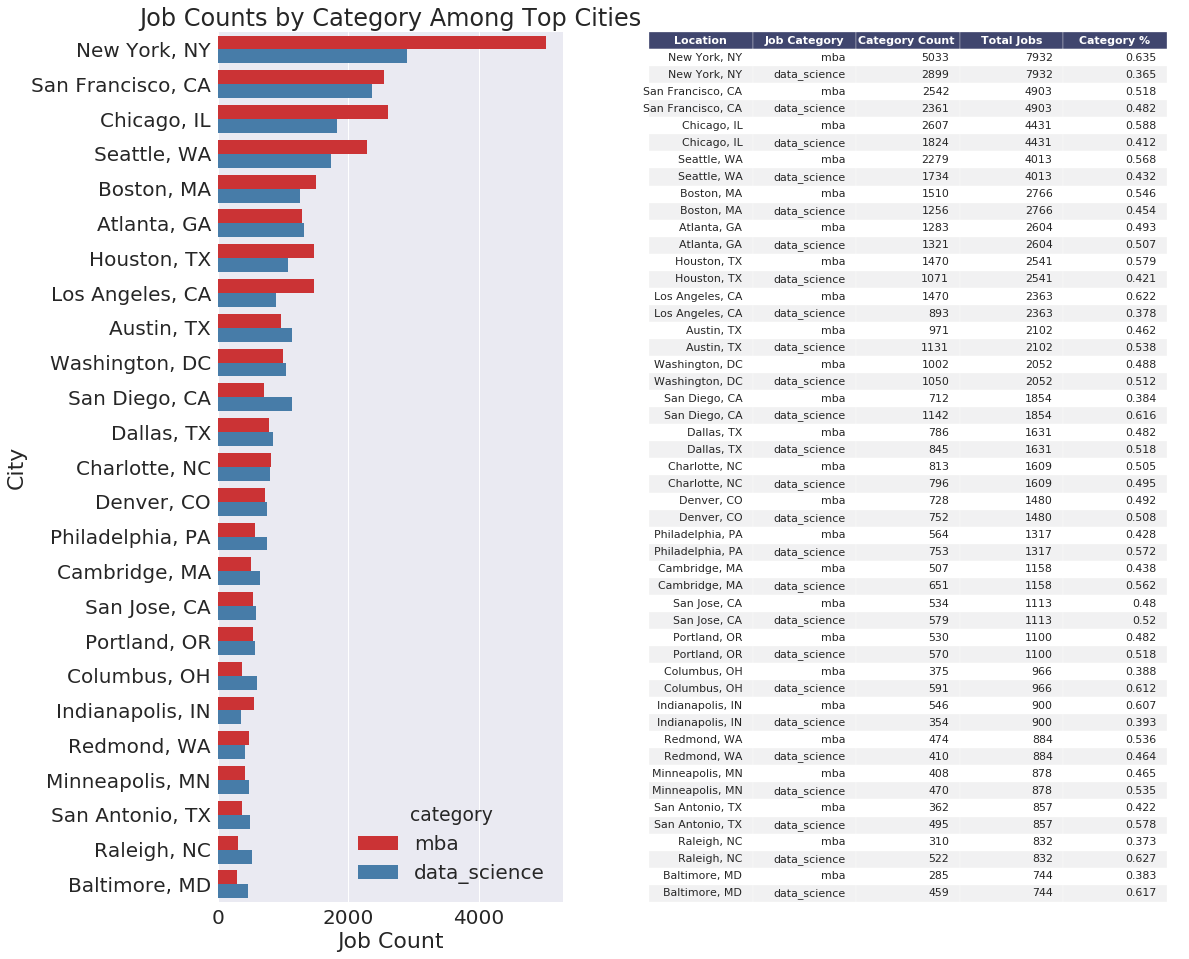

In [26]:
import matplotlib.pyplot as plt
from matplotlib import six
from matplotlib import gridspec
import seaborn as sns

fig = plt.figure(figsize=(17,16))
gs = gridspec.GridSpec(1, 2, width_ratios=[4, 6]) 

ax1 = plt.subplot(gs[0])
current_palette_7 = sns.color_palette("Set1", 2)
sns.set_palette(current_palette_7)
sns.barplot(y='Location', x='cat_count', hue="category", data=city_list_ratio, ax=ax1,linewidth=2.5);
sns.despine(left=True, bottom=True)
ax1.set(xlabel='Job Count', ylabel='City');
ax1.set_title('Job Counts by Category Among Top Cities')

ax2 = plt.subplot(gs[1])
ax2.axis('off')
# col_width=20.0
# row_height=2
font_size=11
header_color='#40466e'
row_colors=['#f1f1f2', 'w']
edge_color='w'
bbox=[0, 0, 1, 1]
header_columns=0

mpl_table = ax2.table(cellText = df1.values, 
                      bbox=bbox, colLabels=['Location','Job Category','Category Count ','Total Jobs','Category %'])

mpl_table.auto_set_font_size(False)
mpl_table.set_fontsize(font_size)

for k, cell in six.iteritems(mpl_table._cells):
    cell.set_edgecolor(edge_color)
    if k[0] == 0 or k[1] < header_columns:
        cell.set_text_props(weight='bold', color='w', wrap=True)
        cell.set_facecolor(header_color)
    else:
        cell.set_facecolor(row_colors[k[0]%len(row_colors) ])

### Companies

#### Top Companies by Category

Who are the top hiring companies for data scientists? For MBA's? Amazon and Microsoft are at the top in both categories.  The importance of Data Science in the financial sector is evident by the presence of several banks near the top of that category's list.

In [27]:
ds_job_comps = pd.DataFrame((df_data_sci_clean
     .groupby('Company')
     .count()
     .sort_values('Location',ascending=False)['Location']
     .reset_index()))
mba_job_comps = pd.DataFrame((df_mba_clean
     .groupby('Company')
     .count()
     .sort_values('Location',ascending=False)['Location']
     .reset_index()))
combined_comps = pd.concat([mba_job_comps, ds_job_comps], axis=1)
combined_comps.columns = ['MBA_Companies','Job_Counts',
                         'DS_Companies','Job_Counts']

In [28]:
combined_comps.head(20)

,MBA_Companies,Job_Counts,DS_Companies,Job_Counts
0,Amazon Corporate LLC,1134.0,Leidos,752
1,Microsoft,662.0,Amazon Corporate LLC,646
2,JP Morgan Chase,513.0,Microsoft,411
3,Emerson,439.0,Wells Fargo,318
4,Wells Fargo,371.0,FedEx Office,277
5,Michael Page US,369.0,Northrop Grumman,251
6,Bank of America,289.0,JP Morgan Chase,230
7,"Anthem, Inc.",274.0,Global Payments,222
8,"Amazon Web Services, Inc.",252.0,PricewaterhouseCoopers LLC,201
9,Google,235.0,Axius Technologies,182


#### Top Companies by City

Lets take a look at the top 5 companies hiring in each of the top 20 cities as measured by the number of postings they have.  We group by city and then by company, sorting by record count to display city and company ranks below.

##### Data Science

For Data Science, quite a few universities and hospital systems make the list in nearly every city.  Banks, tech firms and pharmeaceautical companies are also at the top.

In [29]:
# group by city, company and create company ranks based on number of jobs
ds_top_company_by_city = pd.DataFrame(df_data_sci_clean.groupby(['Location','Company']).size().reset_index())
ds_top_company_by_city.columns = ['Location','Company','Count']
ds_top_company_by_city.sort_values(['Location','Count'],ascending=False,inplace=True)
ds_top_company_by_city['company_rank'] = ds_top_company_by_city.groupby('Location')['Count'].rank(method='first',ascending=False).astype(int)
# group by city and create city ranks based on number of jobs
city_ranks = pd.DataFrame(df_data_sci_clean.groupby('Location').size().rank(method='first',ascending=False).astype(int).reset_index())
city_ranks.columns = ['Location','city_rank']
ds_top_company_by_city = pd.merge(ds_top_company_by_city,city_ranks,how="inner",on="Location")
ds_top_company_by_city.sort_values(['city_rank','company_rank'],inplace=True)
ds_top_company_by_city = ds_top_company_by_city.groupby('Location').head()[:100]
# del ds_top_company_by_city['company_rank']
del ds_top_company_by_city['city_rank']
ds_top_company_by_city['Count'] = ds_top_company_by_city['Count'].astype(str)
ds_top_company_by_city['Company'] = ds_top_company_by_city[['Company','Count']].apply(lambda x: ': '.join(x), axis=1)
ds_top_company_by_city = ds_top_company_by_city.pivot(index='Location', columns='company_rank', values='Company')
ds_top_company_by_city

company_rank,1,2,3,4,5
Location,,,,,
"Atlanta, GA",Global Payments: 79,"Anthem, Inc.: 26",Children's Healthcare of Atlanta: 26,HUNTER Technical Resources: 23,Capgemini: 20
"Austin, TX",University of Texas at Austin: 25,HomeAway: 23,Leidos: 21,Visa: 21,"Advanced Micro Devices, Inc.: 19"
"Boston, MA",Wayfair: 39,Eliassen Group: 33,Brigham & Women's Hospital(BWH): 31,Harvard University: 23,Boston Children's Hospital: 22
"Cambridge, MA",Biogen: 76,Amazon Corporate LLC: 38,Harvard University: 35,MIT: 25,Takeda Pharmaceutical: 21
"Charlotte, NC",Wells Fargo: 125,Spectrum: 41,Bank of America: 29,Capital Markets Placement: 26,Corning: 23
"Chicago, IL",University of Chicago: 124,Hirewell: 48,Jobspring Partners: 46,Northwestern University: 36,"Blue Cross Blue Shield of IL, MT, NM, OK & TX: 27"
"Columbus, OH",Nationwide Mutual Insurance Company: 65,Ohio State University Medical Center: 47,JP Morgan Chase: 40,Nationwide Children's Hospital: 36,Battelle: 23
"Dallas, TX",UT Southwestern Medical Center: 100,Workbridge Associates: 20,Southwest Airlines: 17,JP Morgan Chase: 15,Axius Technologies: 13
"Denver, CO",National Jewish Health: 24,xentity corporation: 20,KPMG: 19,Comcast: 18,State of Colorado Job Opportunities: 17


##### MBA

For MBA jobs, financial firms dominate the list, with a fair representation by tech firms.  4 of the 5 top hiring firms in Seattle are Amazon affiliates.

In [30]:
# group by city, company and create company ranks based on number of jobs
mba_top_company_by_city = pd.DataFrame(df_mba_clean.groupby(['Location','Company']).size().reset_index())
mba_top_company_by_city.columns = ['Location','Company','Count']
mba_top_company_by_city.sort_values(['Location','Count'],ascending=False,inplace=True)
mba_top_company_by_city['company_rank'] = mba_top_company_by_city.groupby('Location')['Count'].rank(method='first',ascending=False).astype(int)
# group by city and create city ranks based on number of jobs
city_ranks = pd.DataFrame(df_mba_clean.groupby('Location').size().rank(method='first',ascending=False).astype(int).reset_index())
city_ranks.columns = ['Location','city_rank']
mba_top_company_by_city = pd.merge(mba_top_company_by_city,city_ranks,how="inner",on="Location")
mba_top_company_by_city.sort_values(['city_rank','company_rank'],inplace=True)
mba_top_company_by_city = mba_top_company_by_city.groupby('Location').head()[:100]
# del mba_top_company_by_city['company_rank']
del mba_top_company_by_city['city_rank']
mba_top_company_by_city['Count'] = mba_top_company_by_city['Count'].astype(str)
mba_top_company_by_city['Company'] = mba_top_company_by_city[['Company','Count']].apply(lambda x: ': '.join(x), axis=1)
mba_top_company_by_city = mba_top_company_by_city.pivot(index='Location', columns='company_rank', values='Company')
mba_top_company_by_city

company_rank,1,2,3,4,5
Location,,,,,
"Atlanta, GA",SunTrust: 86,CocaCola: 48,Global Payments: 46,Fidelis Search: 34,Home Depot: 29
"Austin, TX",Emerson: 36,Dell: 35,Vista Equity Partners: 29,Visa: 23,HomeAway: 19
"Boston, MA",Wayfair: 116,State Street: 100,Liberty Mutual: 43,WinterWyman: 23,Michael Page US: 22
"Cambridge, MA",Biogen: 112,Sanofi US: 34,Harvard University: 23,Takeda Pharmaceutical: 19,MIT: 16
"Charlotte, NC",Wells Fargo: 93,Bank of America: 67,Sealed Air Corporation: 31,Duke Energy: 19,Player Financial Resources: 18
"Chicago, IL",University of Chicago: 102,United Airlines Inc.: 94,JP Morgan Chase: 42,Kraft Heinz Company: 41,BMO Financial Group: 40
"Dallas, TX","Brand Protection Agency, LLC: 56",Toyota: 46,CBRE: 31,JP Morgan Chase: 24,AT&T: 23
"Denver, CO",Marketo: 22,Sunflower Bank: 21,University of Denver: 13,Deloitte: 12,Verizon: 11
"Houston, TX",Emerson: 80,HP: 35,Houston Methodist: 32,Rice University: 24,ExxonMobil: 23


#### Top Company Category Ratios

Among our top hirers, it is harder to find those with near even splits between MBA and Data Science positions. The ratio is lopsided one way or the other with Wells Fargo coming to closest to having an even split.

In [31]:
company_list_ratio = pd.DataFrame(df_combined
                               .groupby(['Company','category'])
                               .size()).reset_index().sort_values(0,ascending=False)
company_list_totals = company_list_ratio.groupby("Company").agg({0:np.sum})
company_list_totals['Company'] = company_list_totals.index
company_list_ratio = company_list_ratio.merge(company_list_totals,how="inner",on="Company")
company_list_ratio.columns = ["Company","category","cat_count","tot_count"]
company_list_ratio['cat_pct'] = company_list_ratio['cat_count']/company_list_ratio['tot_count']
company_list_ratio = company_list_ratio.sort_values(['tot_count','Company','category'],ascending=False)
company_list_ratio = company_list_ratio.head(50)
df1 = pd.DataFrame(company_list_ratio.head(50))
df1['cat_pct'] = 100*round(df1['cat_pct'],3)
df1['cat_pct'] = df1['cat_pct'].map('{:,.2f}%'.format)
#Abbreviations for chart
df1['Company'] = np.where(df1['Company']=="Amazon Web Services, Inc.","AWS",df1['Company'])
df1['Company'] = np.where(df1['Company']=="PricewaterhouseCoopers LLC","PWC",df1['Company'])
df1['Company'] = np.where(df1['Company']=="Johnson & Johnson Family of Companies","J&J",df1['Company'])

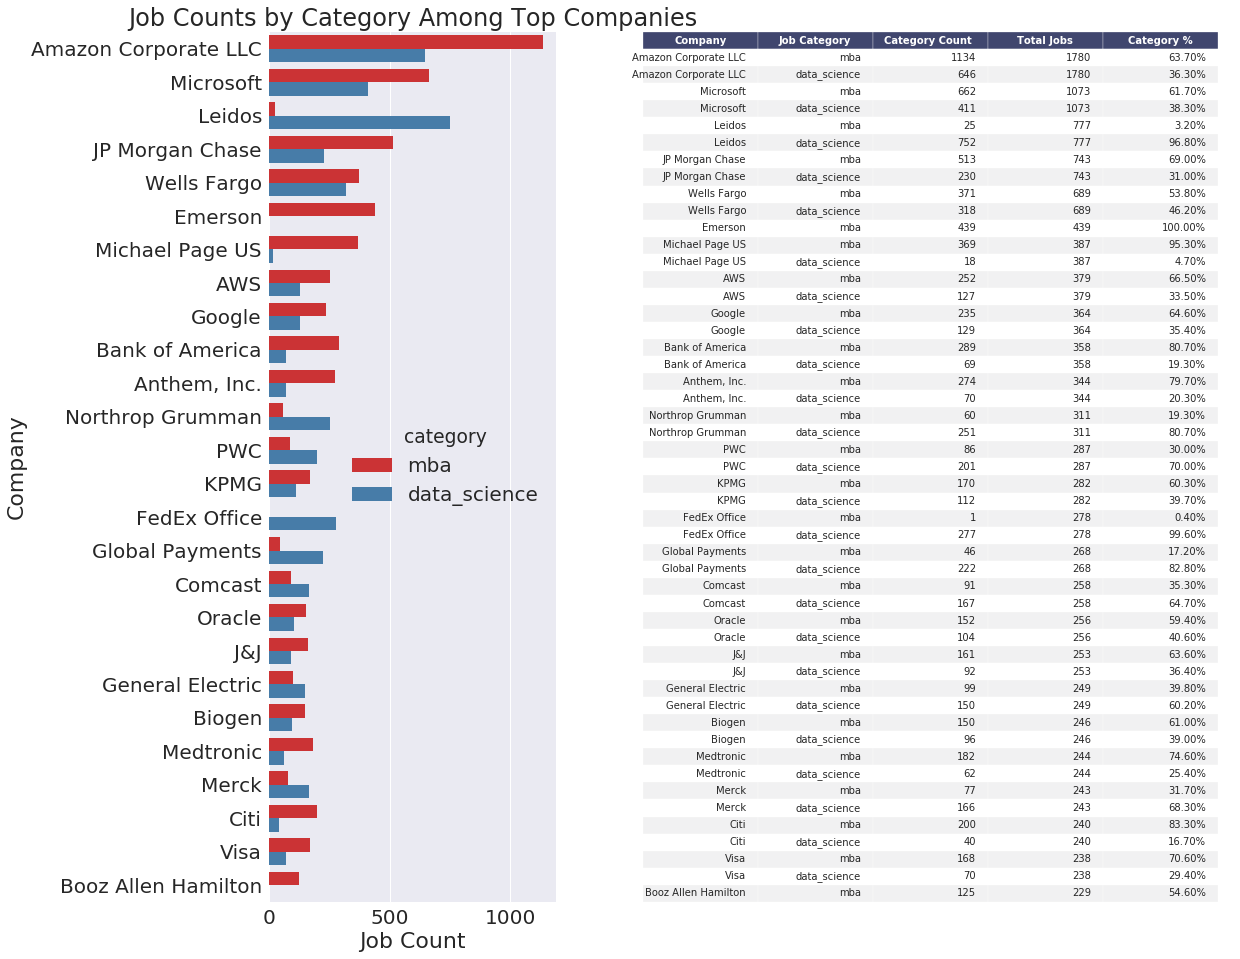

In [32]:
import matplotlib.pyplot as plt
from matplotlib import six
from matplotlib import gridspec
import seaborn as sns

fig = plt.figure(figsize=(17,16))
gs = gridspec.GridSpec(1, 2, width_ratios=[3, 6]) 

ax1 = plt.subplot(gs[0])

current_palette_7 = sns.color_palette("Set1", 2)
sns.set_palette(current_palette_7)
sns.barplot(y='Company', x='cat_count', hue="category", data=company_list_ratio, ax=ax1,linewidth=2.5);
sns.despine(left=True, bottom=True)
ax1.set(xlabel='Job Count', ylabel='Company');
ax1.set_title('Job Counts by Category Among Top Companies')

ax2 = plt.subplot(gs[1])
ax2.axis('off')
# col_width=20.0
# row_height=2
font_size=10
header_color='#40466e'
row_colors=['#f1f1f2', 'w']
edge_color='w'
bbox=[0, 0, 1, 1]
header_columns=0

mpl_table = ax2.table(cellText = df1.values, 
                      bbox=bbox, colLabels=['Company','Job Category','Category Count ','Total Jobs','Category %'])

mpl_table.auto_set_font_size(False)
mpl_table.set_fontsize(font_size)

for k, cell in six.iteritems(mpl_table._cells):
    cell.set_edgecolor(edge_color)
    if k[0] == 0 or k[1] < header_columns:
        cell.set_text_props(weight='bold', color='w', wrap=True)
        cell.set_facecolor(header_color)
    else:
        cell.set_facecolor(row_colors[k[0]%len(row_colors) ])

#### Company Clusters

Now lets take a look at how the companies are clustered based on their job description text.  The clustering algorithm we will use is **K-Means** which we discussed above.  Company clusters will be estimated based on the text associated with job postings for a given city.  To accomplish this we will interate through the first 100 cities, pull all text for that company's postings into a corpus and then run the K-Means algorithm.

In [33]:
top_companies = pd.DataFrame(df_combined_clean.groupby("Company").size().sort_values(ascending=False)[:100])
top_companies.reset_index(inplace=True)
top_companies.columns = ["Company","Count"]
top_companies['text'] = ""

for idx, row in top_companies.iterrows():
    top_companies['text'][idx]= df_combined_clean[df_combined_clean['Company']==\
                                           top_companies['Company'][idx]]['Snippet'].values

top_companies['text'] = top_companies['text'].astype(str)

In [34]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_transformer = Pipeline([
                ('tfidf', TfidfVectorizer())])
tfidf_dat = tfidf_transformer.fit_transform(top_companies['text'])

In [35]:
from sklearn.cluster import KMeans
distortions = []
for i in range(1,10):
    km = KMeans(n_clusters=i,n_init=10,
               max_iter=1000,random_state=99)
    km.fit(tfidf_dat)
    distortions.append(km.inertia_)

The most obvious "elbow" we see forms at the two cluster mark.  Lets use two clusters and see how that separates the companies in our dataset.

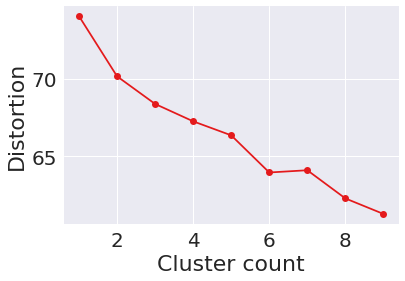

In [36]:
%matplotlib inline

import matplotlib.pyplot as plt
plt.plot(range(1,10),distortions,marker='o')
plt.xlabel('Cluster count')
plt.ylabel('Distortion')
plt.show;

In [37]:
km = KMeans(n_clusters=2,n_init=10,
           max_iter=1000,random_state=101)
km.fit(tfidf_dat)
top_companies['cluster_num'] = km.labels_

In [39]:
df_cluster_one = top_companies[top_companies['cluster_num']==0]
df_cluster_two = top_companies[top_companies['cluster_num']==1]

If we iterate over the clusters and look at the top 10 words occuring each, we can get a general idea of what types of jobs are contained in each cluster.  We see the following:
* Cluster 1 contains terms like "engineering" and "technical".  A good description for this cluster might be "Technical & Engineering"
* Cluster 2 contains terms like "business" and "management".  Let's name this cluster "Business & Management"

These two clusters seem to capture some of the nature behind our problem, differentiating MBA jobs from Data Science jobs.

In [40]:
from collections import Counter
for i in range(2):
    cluster = top_companies[top_companies['cluster_num']==i]
    result = Counter(" ".join(cluster["text"].values.tolist()).split(" "))
    word_counts_cluster = pd.DataFrame.from_dict(result, orient='index').reset_index()
    word_counts_cluster.columns = ['word','count']
    word_counts_cluster.sort_values("count",ascending=False,inplace=True)
    word_counts_cluster.reset_index(inplace=True)
    k = i + 1
    print("Top Words in Cluster %d" % k)
    print(word_counts_cluster.head(10))
    print()

Top Words in Cluster 1
   index         word  count
0  11322  engineering  5700 
1  8971   develop      5681 
2  2866   experience   5526 
3  13826  business     5501 
4  1504   technical    5130 
5  7439   degree       5024 
6  7470   field        4860 
7  5145   design       4636 
8  10891  related      4389 
9  12201  analysis     4119 

Top Words in Cluster 2
   index         word  count
0  9925   degree       2316 
1  9958   field        2186 
2  1881   experience   2037 
3  8598   business     1953 
4  1991   develop      1831 
5  597    management   1687 
6  5826   related      1636 
7  5253   engineering  1591 
8  4357   including    1560 
9  6434   analysis     1523 



In [41]:
cluster_colors = {0:"blue",
                 1:"red"}

cluster_names = {0:"Enginnering & Technical",
                 1:"Buiness & Management"}

In [42]:
from sklearn.manifold import MDS
from sklearn.metrics.pairwise import cosine_similarity
dist = 1 - cosine_similarity(tfidf_dat)

In [43]:
mds = MDS(n_components=2,dissimilarity="precomputed",random_state=99)
coords = mds.fit_transform(dist)
x,y = coords[:,0],coords[:,1]

mds_df = pd.DataFrame(dict(x=x,y=y,
               cluster=top_companies['cluster_num'],
              companies = top_companies['Company']))

clusters = mds_df.groupby('cluster')

Looking at the below plot, we can see how effective our K-Means assigned companies to the three overall clusters we created.
* The Red Cluster, representing postings with Engineering & Technical descriptions is mostly made up of tech companies
* The Blue Cluster, with postings mainly related to research & development, is dominated by universities and pharmaceautical companies.
* The Green Cluster, which postings related to business & analysis is mostly made up of financial and consulting firms with a fair of pharmaceautical companies sprinkled in.

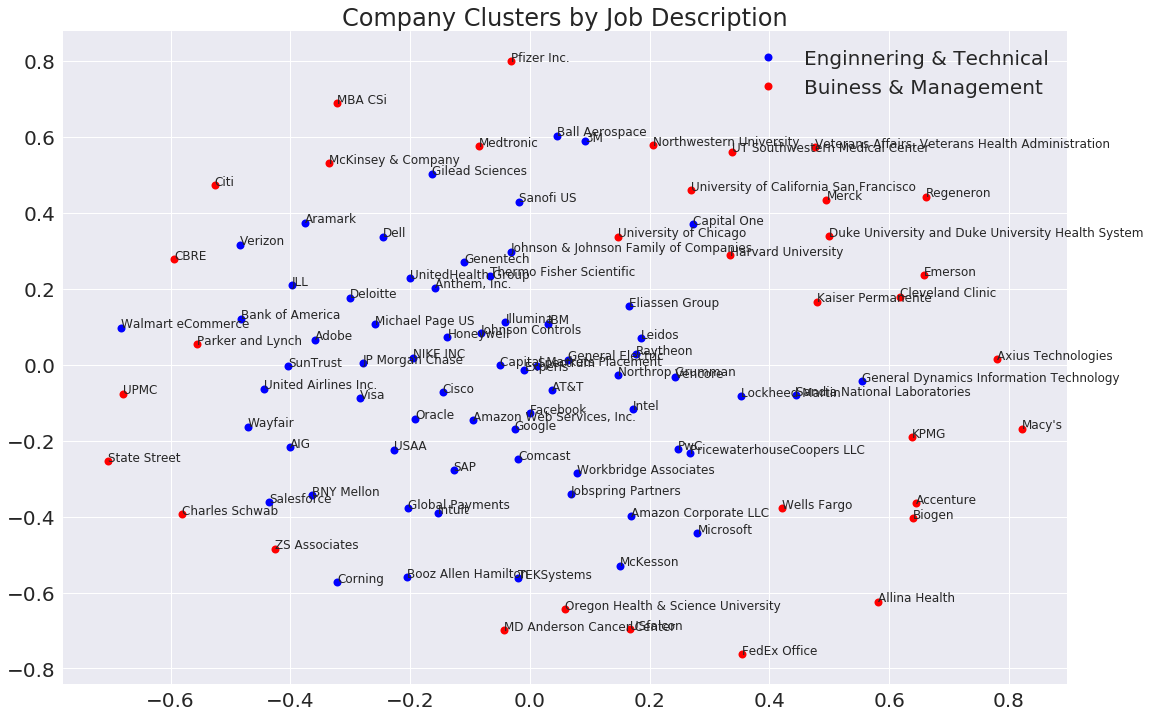

In [44]:
fig, ax = plt.subplots(figsize=(18, 12))

ax.margins(0.05)
for name, group in clusters:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=8, 
            label=cluster_names[name], color=cluster_colors[name])
    
ax.legend(numpoints=1)  
for idx, row in mds_df.iterrows():
    ax.text(row['x'],row['y'],
           row['companies'],size=12)
    
ax.set_title("Company Clusters by Job Description")
    
plt.show()

### Job Titles

#### Top Titles by Category

Looking at the top job titles by job category, many of the top MBA titles have a "manager" suffix, while many of the Data Science titles have an "engineer" suffix.

In [45]:
ds_job_titles = pd.DataFrame((df_data_sci_clean
     .groupby('Job_Title')
     .count()
     .sort_values('Company',ascending=False)['Company']
     .head(20).reset_index()))
mba_job_titles = pd.DataFrame((df_mba_clean
     .groupby('Job_Title')
     .count()
     .sort_values('Company',ascending=False)['Company']
     .head(20).reset_index()))
combined_titles = pd.concat([mba_job_titles,ds_job_titles], axis=1)
combined_titles.columns = ['MBA_Titles','Job_Counts',
                         'DS_Titles','Job_Counts']

In [46]:
combined_titles

,MBA_Titles,Job_Counts,DS_Titles,Job_Counts
0,Financial Analyst,933,Data Scientist,846
1,Product Manager,593,Software Engineer,791
2,Product Marketing Manager,302,Retail Customer Service Associate,267
3,Project Manager,301,Data Analyst,260
4,Controller,296,Data Engineer,259
5,Accountant,246,Software Developer,187
6,Finance Manager,244,Business Analyst,169
7,Program Manager,228,Network Engineer,158
8,Business Analyst,187,Systems Engineer,138
9,Marketing Manager,159,Product Manager,126


#### Even Title Splits

Lets take a look at which job titles have the nearest even split between both categories.  We will use a +/-5% buffer. Business ANalyst is clearly the most commonly split job title, and we see a decent number of other "Analyst" type roles in the mix.  This is a early hint at the overall problem we were trying to solve in finding the "niche" jobs between the two categories.

In [280]:
df_jobs = df_combined_clean.groupby(["Job_Title","category"]).size().unstack().reset_index()
df_jobs['total'] = df_jobs.fillna(0)['data_science']+df_jobs.fillna(0)['mba']
df_jobs['mba_%'] = df_jobs.fillna(0)['mba']/df_jobs.fillna(0)['total']

In [285]:
df_jobs[(df_jobs['mba_%']>0.45) & (df_jobs['mba_%']<0.55)].sort_values(by="total",ascending=False).head(20)

category,Job_Title,data_science,mba,total,mba_%
7052,Business Analyst,169.0,187.0,356.0,0.525281
35521,Marketing Analyst,24.0,23.0,47.0,0.489362
21311,Engineering Manager,22.0,21.0,43.0,0.488372
50465,Scrum Master,19.0,16.0,35.0,0.457143
22052,Executive Assistant,18.0,16.0,34.0,0.470588
7402,Business Data Analyst,14.0,12.0,26.0,0.461538
24059,Financial Systems Analyst,8.0,8.0,16.0,0.500000
54741,Supplier Quality Engineer,8.0,8.0,16.0,0.500000
44253,Project Analyst,8.0,7.0,15.0,0.466667
4655,Associate Director,7.0,8.0,15.0,0.533333


#### Top Titles by City

Similar to the view we made of companies by city earlier, we will now take a look at the top 5 job titles in each of the top 20 cities as measured by the number of postings they have.  We group by city and then by company, sorting by record count to display city and title ranks below.

##### Data Science

Most of the top titles for Data Science postings are, unsuprisingly "Data Scientist".  Developer and software engineer roles are also dominant in every city.

In [47]:
# group by city, company and create company ranks based on number of jobs
ds_top_title_by_city = pd.DataFrame(df_data_sci_clean.groupby(['Location','Job_Title']).size().reset_index())
ds_top_title_by_city.columns = ['Location','Title','Count']
ds_top_title_by_city.sort_values(['Location','Count'],ascending=False,inplace=True)
ds_top_title_by_city['title_rank'] = ds_top_title_by_city.groupby('Location')['Count'].rank(method='first',ascending=False).astype(int)
# ds_top_title_by_city
# group by city and create city ranks based on number of jobs
city_ranks = pd.DataFrame(df_data_sci_clean.groupby('Location').size().rank(method='first',ascending=False).astype(int).reset_index())
city_ranks.columns = ['Location','city_rank']
ds_top_title_by_city = pd.merge(ds_top_title_by_city,city_ranks,how="inner",on="Location")
ds_top_title_by_city.sort_values(['city_rank','title_rank'],inplace=True)
ds_top_title_by_city = ds_top_title_by_city.groupby('Location').head()[:100]
# ds_top_title_by_city
del ds_top_title_by_city['city_rank']
ds_top_title_by_city['Count'] = ds_top_title_by_city['Count'].astype(str)
ds_top_title_by_city['Title'] = ds_top_title_by_city[['Title','Count']].apply(lambda x: ': '.join(x), axis=1)
ds_top_title_by_city = ds_top_title_by_city.pivot(index='Location', columns='title_rank', values='Title')
ds_top_title_by_city

title_rank,1,2,3,4,5
Location,,,,,
"Atlanta, GA",Junior Data Analyst: 29,Information Security Consultant: 27,Data Scientist: 19,Marketing Technologist: 18,Business Analyst: 10
"Austin, TX",Data Scientist: 25,Software Engineer: 20,Data Engineer: 8,Software Developer: 8,Software Development Engineer: 7
"Boston, MA",Data Scientist: 31,Software Engineer: 19,Data Engineer: 9,Project Manager: 7,Quantitative Analyst: 7
"Cambridge, MA",Data Scientist: 18,Software Engineer: 10,Data Analyst: 4,Principal Software Engineer: 4,Research Associate: 4
"Charlotte, NC",Software Developer: 21,Data Scientist: 9,Construction Superintendent: 8,Retail Customer Service Associate: 6,Analytic Consultant 4: 5
"Chicago, IL",Data Scientist: 47,Software Engineer: 39,Data Engineer: 28,Java Developer: 11,DevOps Engineer: 9
"Columbus, OH",Clinical Research Coordinator: 7,Post Doctoral Researcher: 7,"Developer, IT Applications: 6",Retail Customer Service Associate: 6,Student Research Assistant: 6
"Dallas, TX",Software Engineer: 10,Data Analyst: 8,Data Scientist: 6,Application Developer: 5,Java Developer: 5
"Denver, CO",Data Scientist: 14,Software Engineer: 14,Data Analyst: 6,Software Development Engineer: 5,Data Architect: 4


##### MBA

For MBA titles, Financial Analyst, Project Manager and Product Manager appear in the top jobs for nearly every city.

In [48]:
# group by city, company and create company ranks based on number of jobs
mba_top_title_by_city = pd.DataFrame(df_mba_clean.groupby(['Location','Job_Title']).size().reset_index())
mba_top_title_by_city.columns = ['Location','Title','Count']
mba_top_title_by_city.sort_values(['Location','Count'],ascending=False,inplace=True)
mba_top_title_by_city['title_rank'] = mba_top_title_by_city.groupby('Location')['Count'].rank(method='first',ascending=False).astype(int)
# mba_top_title_by_city
# group by city and create city ranks based on number of jobs
city_ranks = pd.DataFrame(df_data_sci_clean.groupby('Location').size().rank(method='first',ascending=False).astype(int).reset_index())
city_ranks.columns = ['Location','city_rank']
mba_top_title_by_city = pd.merge(mba_top_title_by_city,city_ranks,how="inner",on="Location")
mba_top_title_by_city.sort_values(['city_rank','title_rank'],inplace=True)
mba_top_title_by_city = mba_top_title_by_city.groupby('Location').head()[:100]
# mba_top_title_by_city
del mba_top_title_by_city['city_rank']
mba_top_title_by_city['Count'] = mba_top_title_by_city['Count'].astype(str)
mba_top_title_by_city['Title'] = mba_top_title_by_city[['Title','Count']].apply(lambda x: ': '.join(x), axis=1)
mba_top_title_by_city = mba_top_title_by_city.pivot(index='Location', columns='title_rank', values='Title')
mba_top_title_by_city

title_rank,1,2,3,4,5
Location,,,,,
"Atlanta, GA","Analyst, Finance - HPY Payment Processing: 46",Financial Analyst: 25,Staff Accountant: 8,Account Executive: 7,Audit Manager: 7
"Austin, TX",Financial Analyst: 23,Product Manager: 14,Product Marketing Manager: 11,Controller: 9,"Program Manager, Business Applications: 9"
"Boston, MA",Product Manager: 23,Financial Analyst: 21,Project Manager: 17,Product Marketing Manager: 13,Finance Manager: 7
"Cambridge, MA","Manager, Medical Information: 7",Global Program Management Lead: 6,"Director, Business Development and External Innovation: 5","Director, Customer Data & Analytics: 5",Financial Analyst: 5
"Charlotte, NC",Financial Analyst: 15,Product Manager: 9,Accountant: 7,Financial Consultant 4: 7,"Director, Investment Management- Multifamily Sector: 6"
"Chicago, IL",Financial Analyst: 39,Accountant: 19,Project Manager: 15,Product Manager: 14,Engagement Manager: 12
"Columbus, OH",Business Analyst: 9,Financial Analyst: 8,Accountant: 5,"Consumer and Community Bank Finance, Financial Analysis, Associate: 4",Internal Auditor: 4
"Dallas, TX",Solutions Consultant: 56,Financial Analyst: 11,Finance Manager: 9,Project Manager: 8,Treasury Analyst: 6
"Denver, CO",Financial Analyst: 22,Mortgage Loan Originator: 21,Regional Advisor Consultant: 8,Controller: 6,Product Marketing Manager: 6


#### Top Titles by Company

##### Data Science

In [49]:
# group by city, company and create company ranks based on number of jobs
data_sci_top_title_by_company = pd.DataFrame(df_data_sci_clean.groupby(['Company','Job_Title']).size().reset_index())
data_sci_top_title_by_company.columns = ['Company','Title','Count']
data_sci_top_title_by_company.sort_values(['Company','Count'],ascending=False,inplace=True)
data_sci_top_title_by_company['title_rank'] = data_sci_top_title_by_company.groupby('Company')['Count'].rank(method='first',ascending=False).astype(int)
# data_sci_top_title_by_company
# group by city and create city ranks based on number of jobs
city_ranks = pd.DataFrame(df_data_sci_clean.groupby('Company').size().rank(method='first',ascending=False).astype(int).reset_index())
city_ranks.columns = ['Company','city_rank']
data_sci_top_title_by_company = pd.merge(data_sci_top_title_by_company,city_ranks,how="inner",on="Company")
data_sci_top_title_by_company.sort_values(['city_rank','title_rank'],inplace=True)
data_sci_top_title_by_company = data_sci_top_title_by_company.groupby('Company').head()[:100]
# data_sci_top_title_by_company
del data_sci_top_title_by_company['city_rank']
data_sci_top_title_by_company['Count'] = data_sci_top_title_by_company['Count'].astype(str)
data_sci_top_title_by_company['Title'] = data_sci_top_title_by_company[['Title','Count']].apply(lambda x: ': '.join(x), axis=1)
data_sci_top_title_by_company = data_sci_top_title_by_company.pivot(index='Company', columns='title_rank', values='Title')
data_sci_top_title_by_company

title_rank,1,2,3,4,5
Company,,,,,
Amazon Corporate LLC,Software Development Engineer: 72,Software Development Manager: 20,Technical Program Manager: 13,Data Scientist: 11,Applied Scientist: 10
Axius Technologies,Technology Lead- Informatica: 4,Data Scientist: 3,Application Solution Lead: 2,CA LISA: 2,Cygnet Consultant: 2
Comcast,Software Engineer: 10,Data Engineer: 8,Data Analyst: 3,Principal Platform Engineer: 3,"Software Engineer, VIPER Strategic Projects Group: 3"
Duke University and Duke University Health System,CLINICAL RESEARCH NURSE COORDINATOR: 8,CLINICAL RESEARCH COORDINATOR: 6,NURSE PRACTITIONER: 5,RESEARCH TECHNICIAN II: 5,MEDICAL LAB SCIENTIST: 4
Eliassen Group,Business Analyst: 5,Java Developer: 4,Scrum Master: 3,Software Engineer: 3,Agile Coach: 2
FedEx Office,Retail Customer Service Associate: 267,Sales Customer Consultant: 2,Centralized Dispatcher: 1,Client Services Expert: 1,Customer Service Representative: 1
General Dynamics Information Technology,"Analyst, Info Security: 3",Systems Administrator: 3,"Computer Scientist / Engineer - Control Networks and Industrial Network Security (SCADA, ICS): 2","Cyber Security Auditor, Insider Threat, Fraud Waste and Abuse, TS/SCI: 2",Network Engineer: 2
General Electric,Software Engineer: 23,Staff Software Engineer: 11,Data Scientist: 6,Staff Data Scientist: 5,Staff Data Engineer: 4
Global Payments,Infrastructure Administrator: 39,Junior Data Analyst: 29,Information Security Consultant: 25,Quality Assurance Analyst / Software Tester - TouchNet: 25,Data Architect/ETL Tech Lead: 23


##### MBA

In [50]:
# group by city, company and create company ranks based on number of jobs
mba_sci_top_title_by_company = pd.DataFrame(df_mba_clean.groupby(['Company','Job_Title']).size().reset_index())
mba_sci_top_title_by_company.columns = ['Company','Title','Count']
mba_sci_top_title_by_company.sort_values(['Company','Count'],ascending=False,inplace=True)
mba_sci_top_title_by_company['title_rank'] = mba_sci_top_title_by_company.groupby('Company')['Count'].rank(method='first',ascending=False).astype(int)
# mba_sci_top_title_by_company
# group by city and create city ranks based on number of jobs
city_ranks = pd.DataFrame(df_mba_clean.groupby('Company').size().rank(method='first',ascending=False).astype(int).reset_index())
city_ranks.columns = ['Company','city_rank']
mba_sci_top_title_by_company = pd.merge(mba_sci_top_title_by_company,city_ranks,how="inner",on="Company")
mba_sci_top_title_by_company.sort_values(['city_rank','title_rank'],inplace=True)
mba_sci_top_title_by_company = mba_sci_top_title_by_company.groupby('Company').head()[:100]
# mba_sci_top_title_by_company
del mba_sci_top_title_by_company['city_rank']
mba_sci_top_title_by_company['Count'] = mba_sci_top_title_by_company['Count'].astype(str)
mba_sci_top_title_by_company['Title'] = mba_sci_top_title_by_company[['Title','Count']].apply(lambda x: ': '.join(x), axis=1)
mba_sci_top_title_by_company = mba_sci_top_title_by_company.pivot(index='Company', columns='title_rank', values='Title')
mba_sci_top_title_by_company

title_rank,1,2,3,4,5
Company,,,,,
Amazon Corporate LLC,Product Manager: 39,Financial Analyst: 29,Program Manager: 19,Finance Manager: 18,Principal Product Manager: 14
"Amazon Web Services, Inc.",Digital Marketing Manager: 6,Bus Dev and Analytics Manager: 3,Enterprise Migration Architect: 3,Product Manager: 3,Product Manager - Technical: 3
"Anthem, Inc.",Business Development Sales Director: 3,Director II Commercial Product Development/Management: 3,Product Development Director: 3,Product Management Director-129235: 3,"Risk, Controls, and Assurance Internship: 3"
Bank of America,Private Client Advisor II: 16,Small Business Sales Strategy: 12,Trust Specialist: 10,Leasing Credit Officer: 9,Relationship Manager: 9
CBRE,Finance Manager: 21,Transaction Manager: 18,Appraiser: 11,Finance Director: 10,Associate Finance Director: 8
Citi,U.S. CCB ? International Banking Advisor: 3,BP&A Analytics Lead Analyst: 2,Business Development Officer 3: 2,Digital Associate Product Manager: 2,"Financial Accounting Analyst 3 (Buffalo, NY): 2"
Deloitte,SAP Technical - Manager (Technology): 5,TS&A ? IT Mergers & Acquisitions - Manager: 4,Consultant Sourcing & Procurement - eProcurement: 3,Learning Solutions Manager: 3,"Manager Supply Chain & Manufacturing Operations, Product Development: 3"
Emerson,Inside Sales Engineer: 12,Order Mgmt Analyst: 6,Pricing Specialist: 5,Technical Sales Representative: 5,Financial Analyst: 4
Google,"Product Manager, Google Cloud: 6","Strategic Customer Engineer, Google Cloud: 6","Technical Curriculum Developer, Google Cloud Platform: 5","Customer Solutions Engineer, Ads, Google Technical Services: 4",Product Manager - Google Cloud Platform: 4


#### Job-Title Clusters

As we did before, let's take a look at how the job titles are clustered based on their job description text.  The clustering algorithm we will use is **K-Means** which we discussed above.  Job title clusters will be estimated based on the text associated with job postings for a given job title.  To accomplish this we will interate through the most frequent 100 job titles, pull all text for that job description's postings into a corpus and then run the K-Means algorithm.

In [51]:
top_titles = pd.DataFrame(df_combined_clean.groupby("Job_Title").size().sort_values(ascending=False)[:100])
top_titles.reset_index(inplace=True)
top_titles.columns = ["Job_Title","Count"]
top_titles['text'] = ""

for idx, row in top_titles.iterrows():
    top_titles['text'][idx]= df_combined_clean[df_combined_clean['Job_Title']==\
                                           top_titles['Job_Title'][idx]]['Snippet'].values

top_titles['text'] = top_titles['text'].astype(str)

In [52]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_transformer = Pipeline([
                ('tfidf', TfidfVectorizer())])
tfidf_dat = tfidf_transformer.fit_transform(top_titles['text'])

In [53]:
from sklearn.cluster import KMeans
distortions = []
for i in range(1,10):
    km = KMeans(n_clusters=i,n_init=10,
               max_iter=1000,random_state=99)
    km.fit(tfidf_dat)
    distortions.append(km.inertia_)

**Distortion**.. WIP

Below we plot the distortions for each number of clusters.  The common method for determining the number of clusters is to select the number where the 'elbow' forms.  In the below plot we can see an elbow forming around the the 4th cluster mark so we will go with 4 clusters.

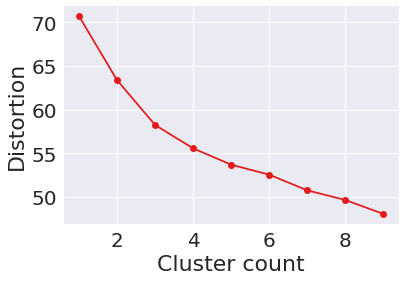

In [54]:
%matplotlib inline

import matplotlib.pyplot as plt
plt.plot(range(1,10),distortions,marker='o')
plt.xlabel('Cluster count')
plt.ylabel('Distortion')
plt.show;

In [55]:
km = KMeans(n_clusters=3,n_init=10,
           max_iter=1000,random_state=99)
km.fit(tfidf_dat)
top_titles['cluster_num'] = km.labels_

In [56]:
df_cluster_one = top_titles[top_titles['cluster_num']==0]
df_cluster_two = top_titles[top_titles['cluster_num']==1]
df_cluster_three = top_titles[top_titles['cluster_num']==2]

Again, we iterate over the clusters and look at the top words occuring each, we can get a general idea of what types of jobs are contained in each cluster.  We see the following:

* **Cluster 1** contains terms like "financial","accounting" and "analysis".  It seems like we could name this cluster "Business, Analysis"

* **Cluster 2** contains terms like "product', "marketing" and "sales".  Let's name this cluster "Products, Sales & Marketing"

* **Cluster 3** contains terms like "data","computer","engineering".  Let's name this cluster "Data, Software & Engineering"

In [58]:
for i in range(3):
    cluster = top_titles[top_titles['cluster_num']==i]
    result = Counter(" ".join(cluster["text"].values.tolist()).split(" "))
    word_counts_cluster = pd.DataFrame.from_dict(result, orient='index').reset_index()
    word_counts_cluster.columns = ['word','count']
    word_counts_cluster.sort_values("count",ascending=False,inplace=True)
    word_counts_cluster.reset_index(inplace=True)
    k = i + 1
    print("Top Words in Cluster %d" % k)
    print(word_counts_cluster.head(10))
    print()

Top Words in Cluster 1
   index        word  count
0  401    financial   2638 
1  4544   analysis    2100 
2  1784   accounting  1820 
3  6021   business    1238 
4  6751   finance     1184 
5  1333   develop     1033 
6  959    reporting   943  
7  6964   degree      916  
8  416    management  817  
9  2679   experience  797  

Top Words in Cluster 2
   index        word  count
0  5443   product     1935 
1  7472   business    1888 
2  1687   develop     1821 
3  4777   marketing   1767 
4  503    management  1245 
5  8684   field       1239 
6  1676   sales       1119 
7  3305   experience  1095 
8  1703   technical   1081 
9  8653   degree      1080 

Top Words in Cluster 3
   index         word  count
0  9327   data         4257 
1  8387   computer     3575 
2  4116   design       3272 
3  9028   engineering  3262 
4  2297   experience   3208 
5  1170   technical    2989 
6  5976   degree       2949 
7  8685   related      2451 
8  5998   field        2408 
9  7091   develop      

In [63]:
cluster_colors = {0:"blue",
                 1:"yellow",
                 2:"red"}

cluster_names = {0:"Business, Analysis",
                1:"Products, Sales & Marketing",
                2:"Data, Software & Engineering"}

In [64]:
from sklearn.manifold import MDS
from sklearn.metrics.pairwise import cosine_similarity
dist = 1 - cosine_similarity(tfidf_dat)

In [65]:
mds = MDS(n_components=2,dissimilarity="precomputed",random_state=99)
coords = mds.fit_transform(dist)
x,y = coords[:,0],coords[:,1]

mds_df = pd.DataFrame(dict(x=x,y=y,
               cluster=top_titles['cluster_num'],
              job_titles = top_titles['Job_Title']))

clusters = mds_df.groupby('cluster')

From the below plot, it seems that our clustering has captured the various groups of jobs pretty well.  We see the "Business & Data" cluster encapsulating many project management roles like "Project Manager", "Solutions Consultant" and "Business Analyst".  The "Business & Finance" cluster captures most of the finance & accounting-related job titles like "FP&A Manager", "Financial Analyst" and "Accountant".  The "Software & Engineering" cluster does remarkably well at containing the "Engineer" and "Developer" titles.  The "Business & Marketing" cluster also contains most of the "Sales", "Marketing" and "Product management" type roles we have.

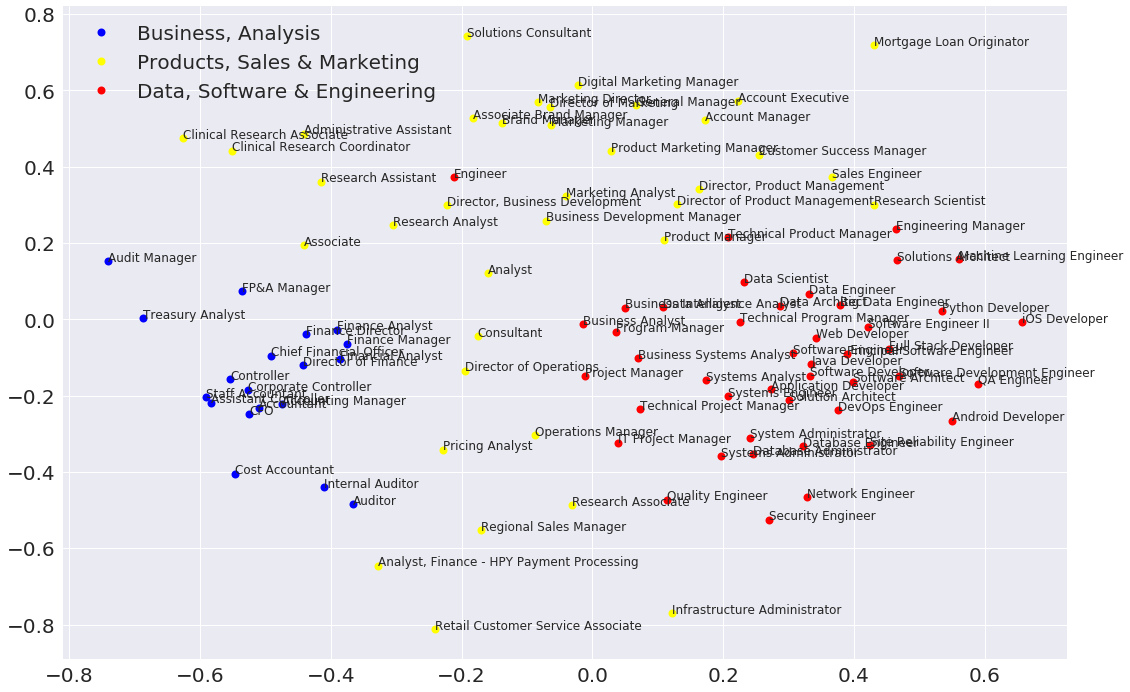

In [66]:
fig, ax = plt.subplots(figsize=(18, 12))

ax.margins(0.05)
for name, group in clusters:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=8, 
            label=cluster_names[name], color=cluster_colors[name])
    
ax.legend(numpoints=1)  
for idx, row in mds_df.iterrows():
    ax.text(row['x'],row['y'],
           row['job_titles'],size=12)
    
plt.show()

# Pre-modeling steps

### Split into Training & Test sets

Before we can train our classification models, several steps need to be taken. The first of which is splitting our dataset into training & test sets.  This is needed in order to determine that our model is not overfitting and classification performance can generalize to new data. We will use a split that puts 80% of our data into a training set and the remaining 20% in a test set.

In [358]:
from sklearn.model_selection import train_test_split
# X_train,X_test,y_train,y_test = train_test_split(df_combined_clean['Snippet'],df_combined_clean['category'],test_size=0.2,train_size=0.8,random_state=1)

X_train, X_test, y_train, y_test = train_test_split(df_combined_clean['Snippet'],
                                                    df_combined_clean['category'],test_size=0.2,train_size=0.8,random_state=1)

# X_train, X_test, y_train, y_test = train_test_split(X_train,y_train,test_size = 0.25,train_size =0.75,random_state=1)

In [359]:
y_train.replace("mba",1,inplace=True)
y_train.replace("data_science",0,inplace=True)

y_test.replace("mba",1,inplace=True)
y_test.replace("data_science",0,inplace=True)

In [360]:
#for later anlaysis (patterns)
X_test_desc = df_combined_clean.loc[X_test.index,"Snippet"]
X_test_locations = df_combined_clean.loc[X_test.index,"Location"]
X_test_companies = df_combined_clean.loc[X_test.index,"Company"]
X_test_titles = df_combined_clean.loc[X_test.index,"Job_Title"]
X_test_category = df_combined_clean.loc[X_test.index,"category"]

# Model Techniques & Evaluation Metrics

We will follow a uniform series of steps for executing the modeling phase, these techniques are used in order to maximize the performance of our specific models.  While the various tuning parameters might vary from one model to the next, the below practices are widely applicable to most of the models we will train in the following sections and classification machine learning problems in general.

### K-fold Cross-Validation

**K-Fold Cross Validation** is a model performance estimation technique which is popular in machine learning.

With K-Fold Cross Validation, the training dataset is randomly split into k folds without replacement.  K-1 folds are used for training the model while the kth fold is used for model testing.  This process is then repeated k times. 

K-fold cross validation is typically used for model tuning, or finding the optimal hyperparameter values that yield good model performance.  Once this process is completed, we can then use those optimal hyperparameter values to train our model on the test set.

You can read more about k-fold cross validation [here](http://scikit-learn.org/stable/modules/cross_validation.html)

### Grid Search

**Grid Search** is a useful, brute force, iterative technique for optimizing hyperparameters of machine learning estimators.  Grid search iterates though all specified combinations of hyperparameters for a given estimator or alogorithm, trains subsequent models on each and records the model's performance as given by a specified score, such as **Area Under the Curve (AUC)** for classification problems or **Mean Squared Error (MSE)** for prediction problems. In this analysis, the metric we use to inform of us of our hyperparameters will be AUC.

You can read more about grid search [here](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html)

### Performance Metrics

To assess the performance of our models, we will use a variety of performance metrics.  We will define several functions to output plots of these metrics below. Below we explain each and provide the associated functions.

##### Confusion Matrix

A **Confusion Matrix** is a ....

Rows in the confusion matrix represent 'actual' classes, while columns represent 'predicted' classes.  From a confusion matrix, we can derive the following performance metrics, which will inform us as to the specific strengths and shortcomings of our models.

A sample confusion matrix looks like this: WIP image


We will define a function to create confusion matrices for our models as follows:

##### Error and Accuracy

The prediction or classification error and accuracy give an overall picture of how many cases are misclassified by a given model.
* **Error** is the sum of all false predictions divided by the sum of total predictions.  As defined below:

\begin{equation*}
Error = \frac{FP+FN}{FP+FN+TP+TN}
\end{equation*}

* **Accuracy** is the sum of all true predictions divided by the sum of total predictions. As defined below:

\begin{equation*}
Accuracy = \frac{TP+TN}{FP+FN+TP+TN}
\end{equation*}

##### True Positive Rate (TPR) & False Positive Rate (FPR)

**True Positive Rate (TPR)** provides the number of positive observations that were correctly identified out of the total number of positives.

\begin{equation*}
TPR = \frac{TP}{P} + \frac{TP}{FN+TP}
\end{equation*}


**False Positive Rate (FPR)** is the ratio of negative samples that are incorrectly classified as positive out of the total number of negatives.

\begin{equation*}
FPR = \frac{FP}{N} + \frac{FP}{FP+TN}
\end{equation*}

##### Precision & Recall

**Precision** is the accuracy of the positive predictions.  As a rule, a **Precision/Recall Tradeoff** exists, whereby increasing precision reduces recall and vice versa.

\begin{equation*}
Precision = \frac{TP}{TP+FP}
\end{equation*}

**Recall**, also called **Sensitivity** or the **True Positive Rate**, is the ratio of positive instances that are correctly detected by the classifier.

\begin{equation*}
Recall = TPR = \frac{TP}{FN+TP}
\end{equation*}

##### F1 Score

**F1 Score** is a combination of precision and recall and favors classes with similar precision and recall measures.  

\begin{equation*}
F1 = 2 * \frac{Precision * Recall}{Precision + Recall}
\end{equation*}

##### ROC Curve

The **Receiver Operating Characeristic (ROC) curve** is a useful tool for binary classification evaluation and plots the TPR against the FPR or Sensitivity (Recall) versus 1-Specificity.

The ideal ROC Curve has a TPR of 1 and a FPR of 0 or an **Area Under the Curve (AUC)** of 1. Therefore, the AUC characterizes the performance of the model.  A sample ROC Curve looks like this.

WIP-image

We will go ahead and define a function that will plot our confusion matrix and our ROC curve side-by-side so that we can evaluate the performance of a classifiers.

In [69]:
def show_clf_perf(width,height,classifier,y_test,y_pred,y_score):
    import matplotlib.pyplot as plt
    from matplotlib import six
    from matplotlib import gridspec
    import seaborn as sns
    fig = plt.figure(figsize=(width,height))
    gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1]) 
    ax1 = plt.subplot(gs[0])
    from sklearn.metrics import confusion_matrix
    confmat = confusion_matrix(y_true=y_test, y_pred=y_pred)
    ax1.matshow(confmat,cmap=plt.cm.Blues,alpha=0.3)
    for i in range(confmat.shape[0]):
        for j in range(confmat.shape[1]):
            ax1.text(x=j,y=i,s=confmat[i,j],
                   va='center',ha='center',size=20)
    
    from sklearn.metrics import accuracy_score
    accuracy_score = accuracy_score(y_true=y_test,y_pred=y_pred)
    
    ax1.text(.9, .1,'Test Accuracy=%s'% round(accuracy_score,5), 
         ha='center', size=20, va='center', transform=ax1.transAxes,color="red")
    
    ax1.set_title("Confusion Matrix")
    ax1.set_xlabel("Predicted MBA")
    ax1.set_ylabel("Actual MBA")

    sns.despine(left=True, bottom=True)
    
    ax2 = plt.subplot(gs[1])
    
    from sklearn.metrics import roc_curve, auc, roc_auc_score

    fpr,tpr,thresholds = roc_curve(y_true=y_test,y_score=y_score,pos_label=1)
    auc = roc_auc_score(y_true=y_test,y_score=y_score)
    
    ax2.plot(fpr,tpr,linewidth=2,label=None)
    ax2.plot([0,1],[0,1],'k--')
    ax2.text(.9, .1,'Test AUC=%s'% round(auc,5),size=20, 
             ha='center', va='center', transform=ax2.transAxes,color="red")

    ax2.set_title("ROC Curve")
    plt.show()
 
    return gs;

# Training Classifiers

We are ready to begin training and tuning our classification models.  As a reminder, our goal is to correctly classify as many job postings under their actual category (Data Science vs MBA).

To do this we will train six individual models by fitting and tuning their hyperparameters on the training set:

* Logistic Regression Classifier
* K Nearest Neighbors Classifier
* Naive Bayes Classifier
* Support Vector Machine Classifier
* Stochastic Gradient Descent Classifier
* Random Forest Classifier

## Logistic Regression

**Logistic Regression** is a popular, easily implentable linear model classification technique that works with linearly separable data.  Logistic Regression is a probabalistic model that uses a concept called an **Odds Ratio**.  This ratio is the odds in favor of an instance belong to a particular class.  Logistic regression takes the logarithm of the odds ratio to create the so-called **Logit Function** and then takes the inverse of the logit function to produce the **Logistic Function**.  This function produces an output between 0 and 1 which can be interpreted as the probability of a particular observation or sample belonging to the predicted class.  The probability threshold for determining which class is typically 50%, but this can be adjusted depending on the requirements of the problem.

**Regularization**

Regularization is the process of adding a penalty term to the cost function in order to yield smaller coefficient weights, in this way regularization introduces bias to the model.  When employing regularization, the goal is to find the combination of coefficient weights that optimize the cost function of our model while simeltaneously allowing the model to generalize well on new data (bias-variance tradeoff).  More generally, regularization is a tool we use to strike a balance between overfitting (high variance) and underfitting (high vias). In additional, regularization can also help combat multicolinearity among model features and filter out noise from data. With logistic regression, the cost function we are trying to **maximize** through regularization is called the **Log-Likelihood**.

**Hyperparameters explored:**
* Regularization penalty types:
    * L1 - Yields sparse feature vectors where most feature weights become zero.
    * L2 - Penalizes large individual coefficient weights, shrinking them towards zero.
* Inverse of Regularization Strength (C):
    * Decreased values of the inverse regularization parameter yields increased regularization strength.

In [181]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve, auc
from sklearn.cross_validation import *

In [182]:
from sklearn.linear_model import LogisticRegression
# GRID SEARCH
###############################################################################
# lr_clf = Pipeline([
#                 ('vect', CountVectorizer()),
#                 ('tfidf', TfidfTransformer()),
#                 ('clf', LogisticRegression(class_weight="balanced",
#                                            n_jobs=-1,
#                                            random_state=1,
#                                            max_iter=1000))])

# parameters = {'clf__penalty':['l1','l2'],
#               'clf__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}

# lr_clf = GridSearchCV(lr_clf, param_grid=parameters, scoring='accuracy',n_jobs=-1,cv=10,verbose=0)
    
# lr_clf.best_params_
# {'clf__C': 10, 'clf__penalty': 'l2'}
    
###############################################################################
#FINAL MODEL

lr_clf = Pipeline([
                ('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', LogisticRegression(class_weight="balanced",
                                           n_jobs=-1,
                                           random_state=1,
                                           max_iter=1000,
                                          C=10,
                                          penalty='l2'))
])                   

lr_clf.fit(X_train, y_train)
y_pred = lr_clf.predict(X_test)
y_score = lr_clf.decision_function(X_test)

lr_y_wrong = y_test[y_test!=y_pred]

/usr/local/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))


##### Performance

Our logistic regression model has an accuracy of 88.4% with an AUC of .948.
Precision and recall are comparable for both classes.

In [183]:
from sklearn.metrics import accuracy_score
print('Accuracy: %.3f' %accuracy_score(y_true=y_test,y_pred=y_pred))
lr_clf_acc = accuracy_score(y_true=y_test,y_pred=y_pred)

from sklearn import metrics
print(metrics.classification_report(y_test,y_pred))

Accuracy: 0.884
             precision    recall  f1-score   support

          0       0.89      0.88      0.88     10113
          1       0.88      0.89      0.88      9887

avg / total       0.88      0.88      0.88     20000



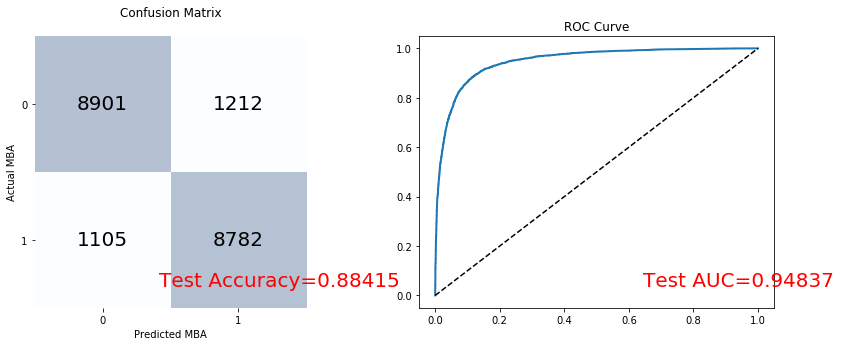

In [184]:
show_clf_perf(14,5,lr_clf,y_test,y_pred,y_score);

## K Nearest Neighbors

**K Nearest Neighbors (KNN)** is a non-parametric algorithm. KNN has been called a **lazy** learning algorithm due to the fact that it does not learn a discriminative function from the training data, but instead memorizes the data. These non-parametric algorithms cannot be characterized by a fixed set of parameters like logistic regression, but instead are characterized as the dataset grows in size.  An example of another non-parametric algorithm is random forests, which we will explore later. KNN belongs to a subset of non-parametric algorithms called **instance-based learners**.  

The biggest advantage of non-parametric, memory-based approaches, is the classifier's ability to adapt well to new training data.  

However, with non-parametric algorithms, computational complexity grows linearly with the size of the training data, leading to computationally expensive models.  It is also worth noting that KNN is susceptable to underforming in high-dimensionality datasets.

KNN runs based on the following steps:
* Given a pre-selected number of K neighbors and specified distance metric:
    * Find the k nearest neighbors of the sample for classification
    * Assign the class label via majority vote.

**Hyperparameters explored:**
* Number of k nearest neighbors (n_neighbors):
    * Choosing the right value for k is needed to balance overfitting and underfitting.
* Weights (weights):
        * WIP

In [185]:
from sklearn.neighbors import KNeighborsClassifier
# GRID SEARCH
###############################################################################
# knn_clf = Pipeline([('vect', CountVectorizer()),
#                       ('tfidf', TfidfTransformer()),
#                       ('clf', KNeighborsClassifier())
# ])

# parameters = {'clf__weights':['uniform','distance'],
#               'clf__n_neighbors': [5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]}


# knn_clf = GridSearchCV(knn_clf, param_grid=parameters, scoring='accuracy',n_jobs=-1,cv=10,verbose=10)

# knn_clf.best_params_
# {'clf__n_neighbors': 30, 'clf__weights': 'distance'}

# FINAL MODEL
###############################################################################
knn_clf = Pipeline([('vect', CountVectorizer()),
                      ('tfidf', TfidfTransformer()),
                      ('clf', KNeighborsClassifier(n_neighbors=30,
                                                  weights='distance',n_jobs=1))
])

knn_clf.fit(X_train, y_train)
y_pred = knn_clf.predict(X_test)
y_score = knn_clf.predict_proba(X_test)

knn_y_wrong = y_test[y_test!=y_pred]

Our K-Nearest Neighbors model has accuracy of 88.5% with an AUC of .956.  Precision and recall are comparable for both classes.

In [186]:
from sklearn.metrics import accuracy_score
print('Accuracy: %.3f' %accuracy_score(y_true=y_test,y_pred=y_pred))
knn_clf_acc = accuracy_score(y_true=y_test,y_pred=y_pred)

from sklearn import metrics
print(metrics.classification_report(y_test,y_pred))

Accuracy: 0.885
             precision    recall  f1-score   support

          0       0.89      0.88      0.89     10113
          1       0.88      0.89      0.88      9887

avg / total       0.89      0.89      0.89     20000



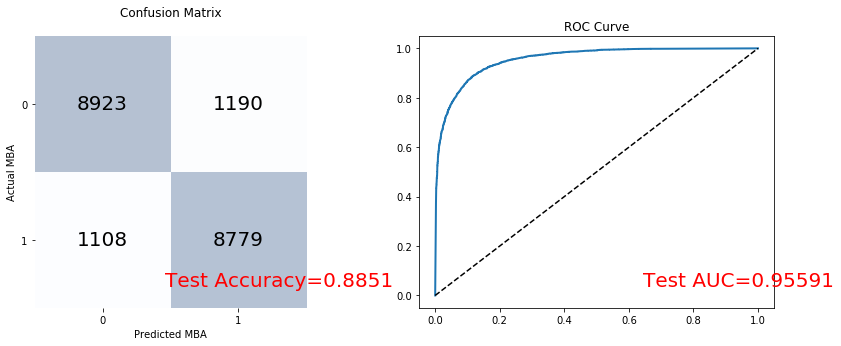

In [187]:
show_clf_perf(14,5,knn_clf,y_test,y_pred,y_score[:,1]);

## Naive Bayes

WIP - Gaussian?

Naive Bayes is a probalistic classifier.  It assumes "naively" assumed independence among the features and relies on ...

Naive Bayes assume that the value of a given feature is independent of the value of any other feature.

https://en.wikipedia.org/wiki/Naive_Bayes_classifier

**Hyperparameters explored:**
* Alpha (alpha):        

In [188]:
from sklearn.naive_bayes import MultinomialNB
# GRID SEARCH
###############################################################################

# nb_clf = Pipeline([('vect', CountVectorizer()),
#                       ('tfidf', TfidfTransformer()),
#                       ('clf', MultinomialNB())
# ])

# parameters = {'clf__alpha': [0.0001,0.001, 0.01, 0.1,1,10,100,1000]}

# nb_clf = GridSearchCV(nb_clf, param_grid=parameters, scoring='accuracy',n_jobs=-1,cv=10,verbose=True)

# nb_clf.best_params_
# {'clf__alpha': 0.1}

# FINAL MODEL
###############################################################################

nb_clf = Pipeline([('vect', CountVectorizer()),
                      ('tfidf', TfidfTransformer()),
                      ('clf', MultinomialNB(alpha=0.1))
])

nb_clf.fit(X_train, y_train)
y_pred = nb_clf.predict(X_test)
y_score = nb_clf.predict_proba(X_test)
nb_y_wrong = y_test[y_test!=y_pred]

Our Naive Bayes classifier has accuracy of 85.5% with an AUC of .929.  Recall is noticebly higher for the positive class (MBA).

In [189]:
from sklearn.metrics import accuracy_score
print('Accuracy: %.3f' %accuracy_score(y_true=y_test,y_pred=y_pred))
nb_clf_acc = accuracy_score(y_true=y_test,y_pred=y_pred)

from sklearn import metrics
print(metrics.classification_report(y_test,y_pred))

Accuracy: 0.855
             precision    recall  f1-score   support

          0       0.87      0.84      0.85     10113
          1       0.84      0.87      0.86      9887

avg / total       0.86      0.86      0.86     20000



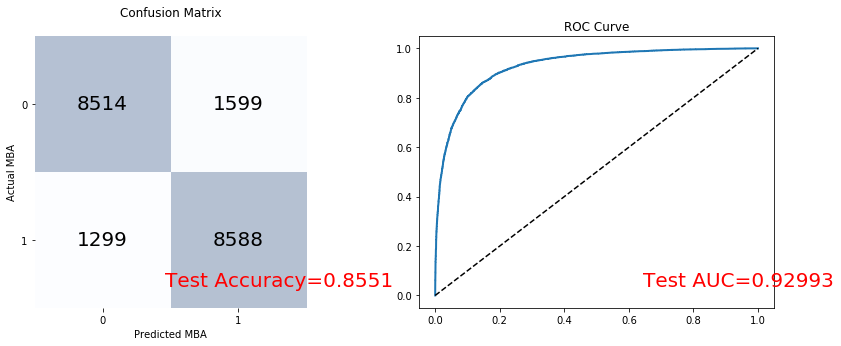

In [190]:
show_clf_perf(14,5,nb_clf,y_test,y_pred,y_score[:,1]);

## Support Vector Machine

**Support Vector Machine (SVM)** is an algorithm which can perform both linear and nonlinear classification. SVM seeks to find the widest possible margin or distance between the decision boundary of the distinct classes and the training samples themselves.  The balancing act in SVM is to keep the gulf between the classes as large as possible while simeltaneously limiting the number of samples that end up in the gulf.  This process is called **soft margin classification**. Decision boundaries with large margins tend to generalize better while those with small margins are more prone to overfitting.

Trained SVMs produce **support vectors** which can be thought of as an instance which is located within the gulf mentioned above.  These support vectors influence the decision boundary.  Additionally, model predictions are made using only these support vectors and not the entire training set.

Similar to how we implemented regularization with logistic regression, we can control the level of cost penalization with SVM, which in turn controls the width of the margin gulf.  This has the same effect of controlling the bias-variance tradeoff.

Use kernels on non-linear datasets.


**Hyperparameters explored:**
* Pemalty for Misclassification (C):
    * A smaller C value leads to a wider gulf but more margin violations.  
    * A higher C value leads to a more narrow gulf with fewer margin volations.
* Kernel:
    * rbf:
    * linear: The classes are linearly separable.  
    * poly: 

In [191]:
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
# GRID SEARCH
###############################################################################

# svm_clf = Pipeline([('vect', CountVectorizer()),
#                       ('tfidf', TfidfTransformer()),
#                       ('clf', SVC(probability=True,class_weight="balanced")),
# ])

# parameters = {'clf__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
#              'clf__kernel': ["rbf","linear","poly"]}

# svm_clf = GridSearchCV(svm_clf, param_grid=parameters, scoring='accuracy',n_jobs=-1,cv=10,verbose=True)

# svm_clf.best_params_
#{'clf__C': 1, 'clf__kernel': 'linear'}

# FINAL MODEL
###############################################################################

svm_clf = Pipeline([('vect', CountVectorizer()),
                      ('tfidf', TfidfTransformer()),
                      ('clf', SVC(probability=False,
                                  class_weight="balanced",
                                 C=1,
                                 kernel="linear"))])

svm_clf.fit(X_train, y_train)
y_pred = svm_clf.predict(X_test)
y_score = svm_clf.decision_function(X_test)
svm_y_wrong = y_test[y_test!=y_pred]

Our SVM model has an accuracy of 88.1% and an AUC of .944.

In [192]:
from sklearn.metrics import accuracy_score
print('Accuracy: %.3f' %accuracy_score(y_true=y_test,y_pred=y_pred))
svm_clf_acc = accuracy_score(y_true=y_test,y_pred=y_pred)
from sklearn import metrics
print(metrics.classification_report(y_test,y_pred))

Accuracy: 0.881
             precision    recall  f1-score   support

          0       0.89      0.88      0.88     10113
          1       0.87      0.89      0.88      9887

avg / total       0.88      0.88      0.88     20000



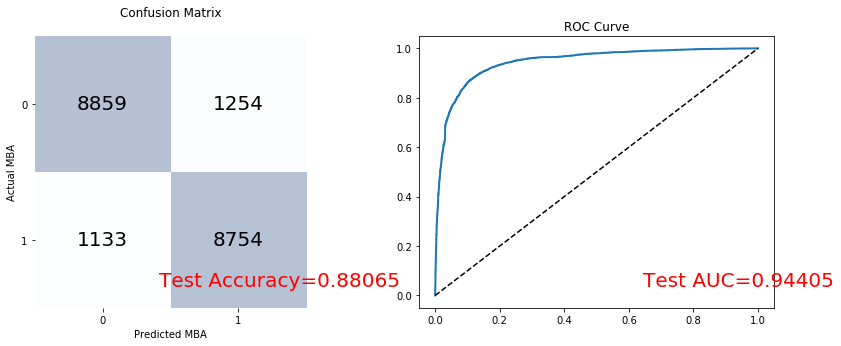

In [193]:
show_clf_perf(14,5,svm_clf,y_test,y_pred,y_score);

## Stochastic Gradient Descent

The Stochastic Gradient Descent (SGD) classifier can handle large datasets efficiently due to....WIP

**Hyperparameters explored:**
* Alpha (alpha):
* Penalty (penalty):
* Loss (loss):

In [194]:
from sklearn.linear_model import SGDClassifier
#GRID SEARCH
##############################################################################
# sgd_clf = Pipeline([('vect', CountVectorizer()),
#                       ('tfidf', TfidfTransformer()),
#                       ('clf', SGDClassifier(class_weight='balanced',
#                                             n_jobs=-1,random_state=1))])

# parameters = {'clf__loss':['log', 'modified_huber', 'perceptron'],
#               'clf__penalty':['none','l2','l1','elasticnet'],
#              'clf__alpha':[0.0001,0.001,0.001,0.01,0.1,1,10,100,1000,10000]}


# sgd_clf = GridSearchCV(sgd_clf, param_grid=parameters, scoring='accuracy',n_jobs=-1,cv=10,verbose=10)

# sgd_clf.best_params_
# {'clf__alpha': 0.0001, 'clf__loss': 'hinge', 'clf__penalty': 'l2'}
#BEST MODEL
##############################################################################

sgd_clf = Pipeline([('vect', CountVectorizer()),
                      ('tfidf', TfidfTransformer()),
                      ('clf', SGDClassifier(class_weight="balanced",
                             alpha=0.0001,
                            loss="log",
                            penalty="l2"))])

sgd_clf.fit(X_train, y_train)
y_pred = sgd_clf.predict(X_test)
y_score = sgd_clf.decision_function(X_test)
sgd_y_wrong = y_test[y_test!=y_pred]

/usr/local/lib/python3.5/site-packages/sklearn/linear_model/stochastic_gradient.py:84: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


Our Stochastic Gradient Descent Classifier has an accuracy of 86.3% and an AUC of 0.932.

In [195]:
from sklearn.metrics import accuracy_score
print('Accuracy: %.3f' %accuracy_score(y_true=y_test,y_pred=y_pred))
sgd_clf_acc = accuracy_score(y_true=y_test,y_pred=y_pred)
from sklearn import metrics
print(metrics.classification_report(y_test,y_pred))

Accuracy: 0.864
             precision    recall  f1-score   support

          0       0.87      0.86      0.86     10113
          1       0.86      0.87      0.86      9887

avg / total       0.86      0.86      0.86     20000



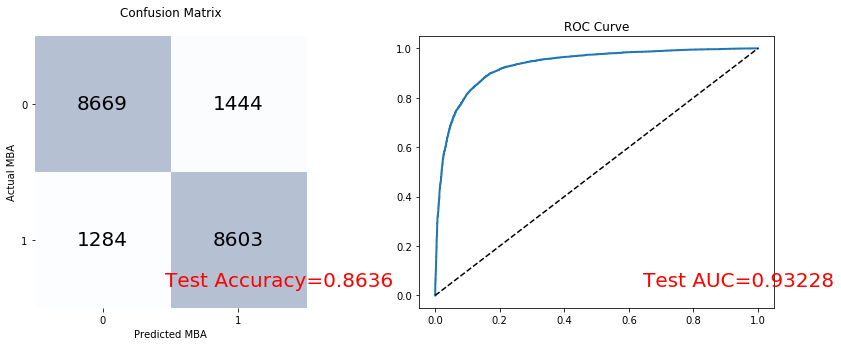

In [196]:
show_clf_perf(14,5,sgd_clf,y_test,y_pred,y_score);

## Random Forest

Random forests fall under the 'ensemble' family of machine learning classifiers.  The model takes a random sample of observations as well as a random subset of features during training which it uses to build decision trees.  

**Hyperparameters explored**:
* Tree size (n_estimators):
    * This parameter specifies the number of trees to be fitted in order to take the aggregate decision (max vote or average prediction).
    * Increasing the tree size will generally improve model accuracy but slow completion time.
* Max Features (max_features):
    * This parameter specifies the maximum number of features the model uses in fitting individual trees.
    * Increasing the max features will typically improve model performance as a higher number of features are being used to fit at each decision node, however doing so will lower the diversity of the tree (and lead to overfitting).
    * The more features used, the longer the model will take to train.
    * Parameter Options include:
        * Use all features (Auto/None)
        * Use the square root of the number of features (sqrt)
        * Use the base log number of features (log2)
        * Use a specified percent of the number of features (0.X)
* Minimum sample leaf (min_sample_leaf):
    * This parameter limits the minimum leaf (or end node) size of the decision tree.
    * Typically larger leaves capture less noise in the training data.
* Decision criterion (criterion):
    * This parameter is the method by which predictions are made by our classifier.
        * **Gini Index:**
            * A measure of node purity.  Smaller values indicate node purity, larger values indicate node impurity.
            * For a split to take place, the Gini index for a child node should be less than that of the parent node.
        * **Entropy:**
            * A measure of node *impurity.* This value ranges between 0 and 1, where 0.5 indicates maximum impurity and the highest uncertainty of making a decision.

In [197]:
from sklearn.ensemble import RandomForestClassifier
# GRID SEARCH
###############################################################################

# forest_clf = Pipeline([('vect', CountVectorizer()),
#                       ('tfidf', TfidfTransformer()),
#                       ('clf', RandomForestClassifier(class_weight='balanced',
#                                          random_state=1))])

# parameters = {'clf__n_estimators': [10,50,100,500,1000],
#              'clf__max_features': ["auto","sqrt","log2"],
#              'clf__min_samples_leaf': [10,25,50,100,200,500],
#              'clf__criterion': ['gini','entropy']}

# forest_clf = GridSearchCV(forest_clf, param_grid=parameters, scoring='accuracy',n_jobs=-1,cv=10,verbose=10)

# forest_clf.best_params_
# {'clf__criterion': 'entropy', 
# 'clf__min_samples_leaf': 10, 
# 'clf__n_estimators': 500, 
# 'clf__max_features': 'auto'}

# FINAL MODEL
###############################################################################
forest_clf = Pipeline([('vect', CountVectorizer()),
                      ('tfidf', TfidfTransformer()),
                      ('clf', RandomForestClassifier(class_weight='balanced',
                              random_state=1,
                              criterion="entropy",
                              min_samples_leaf=10,
                              n_estimators=5000,
                              max_features='auto'))])

forest_clf.fit(X_train, y_train)
y_pred = forest_clf.predict(X_test)
y_score = forest_clf.predict_proba(X_test)
rf_y_wrong = y_test[y_test!=y_pred]

Our Random Forest model has an accuracy of 86% and an AUC of .938.  Precision and recall are very close for both classes.

In [198]:
from sklearn.metrics import accuracy_score
print('Accuracy: %.3f' %accuracy_score(y_true=y_test,y_pred=y_pred))
rf_clf_acc = accuracy_score(y_true=y_test,y_pred=y_pred)
from sklearn import metrics
print(metrics.classification_report(y_test,y_pred))

Accuracy: 0.864
             precision    recall  f1-score   support

          0       0.87      0.86      0.87     10113
          1       0.86      0.86      0.86      9887

avg / total       0.86      0.86      0.86     20000



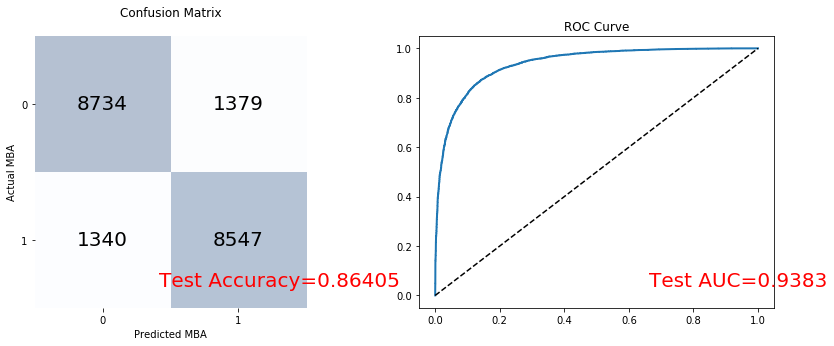

In [199]:
show_clf_perf(14,5,forest_clf,y_test,y_pred,y_score[:,1]);

## Performance Comparison

Reflecting on the performance of our classifiers, we see that K-Nearest Neighbors had the best performance, followed by Logistic Regression and Support Vector Machine.

**K-Nearest Neighbors**, although highly accurate, was an expensive algorithm for this task.  Training the model took many hours, during which my computer was using nearly all of its 32GB of memory.  The slight improvement in accuracy of KNN over Logistic Regression (about 0.1%) might not be worth the cost in time and resources.

**Logistic Regression**, which only took a few minutes to train, performed quite well at only a fraction of the expense.

**Support Vector Machine**, took a long time (over 15 hours) to train, but performed decently coming in third in accuracy.

Interestingly, the **Random Forest** classifier performed rather poorly on this task, coming in fourth.  

**Stochastic Gradient Descent Classifier** performed only a smidgen worse than the Random Forest model.

**Naive Bayes**, a relatively simplistic algorithm, performed the worst.

WIP : Precision was lower for Positive Class (MBA) in all models.

In [269]:
accuracies_list = [lr_clf_acc,knn_clf_acc,nb_clf_acc,
svm_clf_acc,sgd_clf_acc,rf_clf_acc]

In [270]:
accuracies = pd.DataFrame(accuracies_list)
accuracies.columns = ["Accuracy"]
accuracies.index = ["logistic_regression: ","knn: ",
                    "naive_bayes: ","svm :","sgd: ",
                    "random_forest: "]
accuracies.sort_values(by="Accuracy",ascending=False,inplace=True)

In [271]:
accuracies['Accuracy'] = accuracies['Accuracy'].astype(str)
accuracies.index = accuracies.index+accuracies['Accuracy']
accuracies['Accuracy'] = accuracies['Accuracy'].astype(float)

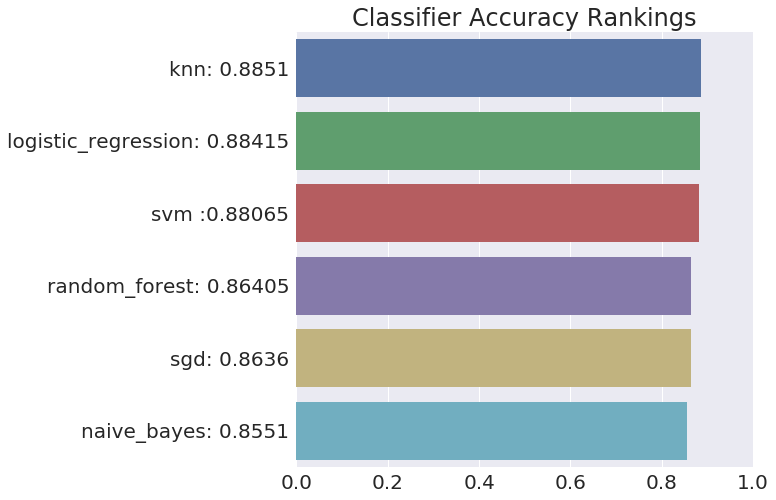

In [272]:
import matplotlib.pyplot as plt
from matplotlib import six
from matplotlib import gridspec
import seaborn as sns
sns.set(font_scale=2)

fig = plt.figure(figsize=(18,8))
gs = gridspec.GridSpec(1, 2, width_ratios=[3, 3]) 
ax1 = plt.subplot(gs[0])

sns.barplot(x=accuracies["Accuracy"],
            y=accuracies.index,
            orient="h",
            order=accuracies.index,
            data=accuracies, ax=ax1,linewidth=2.5);

ax1.set_title("Classifier Accuracy Rankings")
ax1.set_ylabel("")
ax1.set_xlabel("")
ax1.set_xlim(0,1)

gs;

# Finding the Middle Ground

If we remember the **Overall goal** of our analysis, it was to find the "niche" jobs that could appeal to managers hiring both Data Scientists and MBAs.

So, what can our classification models tell us about the divide between MBA and Data Scientist?  The fact that these algorithms can classify one type of job from the other based on the text of the description with high accuracy is sign that these two professions are quite different.

The next question is if there really is a "middle ground", that is a strata of jobs that might be applicable to either an MBA or a Data Scientist.

## Exploring the Worst Predictions

To explore what types of jobs might fall into this homogeneous category, we will take a look at the cases that the algorithms had the hardest time classifying.

In [242]:
# wrong_classifications = pd.concat([lr_y_wrong,knn_y_wrong,
#  nb_y_wrong,svm_y_wrong,
#  sgd_y_wrong,rf_y_wrong])
# wrong_classifications = pd.DataFrame(wrong_classifications)
# dir = "/home/collier/Dropbox/Skills/Python/Projects/Jobs/Classify_Jobs_Indeed/"
# wrong_classifications.to_csv(dir+"misclassifications.csv")

wrong_classifications = pd.read_csv()

NameError: name 'lr_y_wrong' is not defined

Overall, between our 6 classifiers, we had an aggregate 15,358 misclassified job listings.

In [243]:
print("Total Wrong Classifications:")
wrong_classifications.shape

Total Wrong Classifications:


NameError: name 'wrong_classifications' is not defined

If we look further, we see that just under 5000 of these observations are unique. 

This means that most of the misclassifications made by our models were concentrated within a smaller, perhaps more homogenous, set group of listings.

In [275]:
wrong_classifications['index'] = wrong_classifications.index
print("Unique Wrong Classifications:")
wrong_classifications['index'].nunique()

Unique Wrong Classifications:


4903

We see that there is a near even split between the misclassifications in terms of category.

In [125]:
X_test_category[X_test_category.index.isin(wrong_classifications.index)].value_counts()

data_science    2527
mba             2375
Name: category, dtype: int64

##### Top Job Titles

Lets look at the job titles of the top 20 most misclassified jobs from each category.

Product Manager, Project Manager, Program Manager and Business Analyist roles are among the top roles that are most often misclassifed by our classifiers.

These roles might be the most permeable for career seekers from either MBA or Data Science backgrounds, who could be seeking to switch to the other side.

In [361]:
X_misclassified = pd.concat([X_test_category,X_test_companies,
                            X_test_desc,X_test_locations,X_test_titles],axis=1)
X_misclassified = X_misclassified[X_misclassified.index.isin(wrong_classifications.index)]
X_misclassified_titles_mba = X_misclassified[X_misclassified["category"]=="mba"] 
X_misclassified_titles_mba = X_misclassified_titles_mba.groupby(["category","Job_Title"]).size().reset_index()
X_misclassified_titles_mba.columns = ["category","Job_Title","count"]
X_misclassified_titles_mba = X_misclassified_titles_mba.sort_values(by=["category","count"],ascending=False)
X_misclassified_titles_mba.reset_index(inplace=True)
X_misclassified_titles_data_science = X_misclassified[X_misclassified["category"]=="data_science"] 
X_misclassified_titles_data_science = X_misclassified_titles_data_science.groupby(["category","Job_Title"]).size().reset_index()
X_misclassified_titles_data_science.columns = ["category","Job_Title","count"]
X_misclassified_titles_data_science = X_misclassified_titles_data_science.sort_values(by=["category","count"],ascending=False)
X_misclassified_titles_data_science.reset_index(inplace=True)

In [362]:
X_misclassified_all = pd.concat([X_misclassified_titles_mba,X_misclassified_titles_data_science],axis=1)
del X_misclassified_all["index"]
X_misclassified_all.head(20)

,category,Job_Title,count,category,Job_Title,count
0,mba,Product Manager,38.0,data_science,Data Scientist,29
1,mba,Program Manager,27.0,data_science,Product Manager,24
2,mba,Project Manager,23.0,data_science,Business Analyst,17
3,mba,Business Analyst,16.0,data_science,Program Manager,13
4,mba,Data Analyst,10.0,data_science,Project Manager,12
5,mba,Financial Analyst,8.0,data_science,Software Engineer,10
6,mba,Business Systems Analyst,7.0,data_science,Account Executive,7
7,mba,Operations Manager,6.0,data_science,Business Systems Analyst,7
8,mba,Consultant,5.0,data_science,Data Analyst,7
9,mba,"Consultant, Advanced Analytics",5.0,data_science,Quality Engineer,7


Let's also take one last look at the plot we made of the clusters by Job Title.

Aha!  We can see a slew of "product manager","project manager","business analyst" and "program manager" roles on the border area of the "Products, Sales & Marketing" and "Data, Software & Engineering" clusters. The circle added might not do the best job at capturing this area the exact roles, but it is this general area that is interesting.

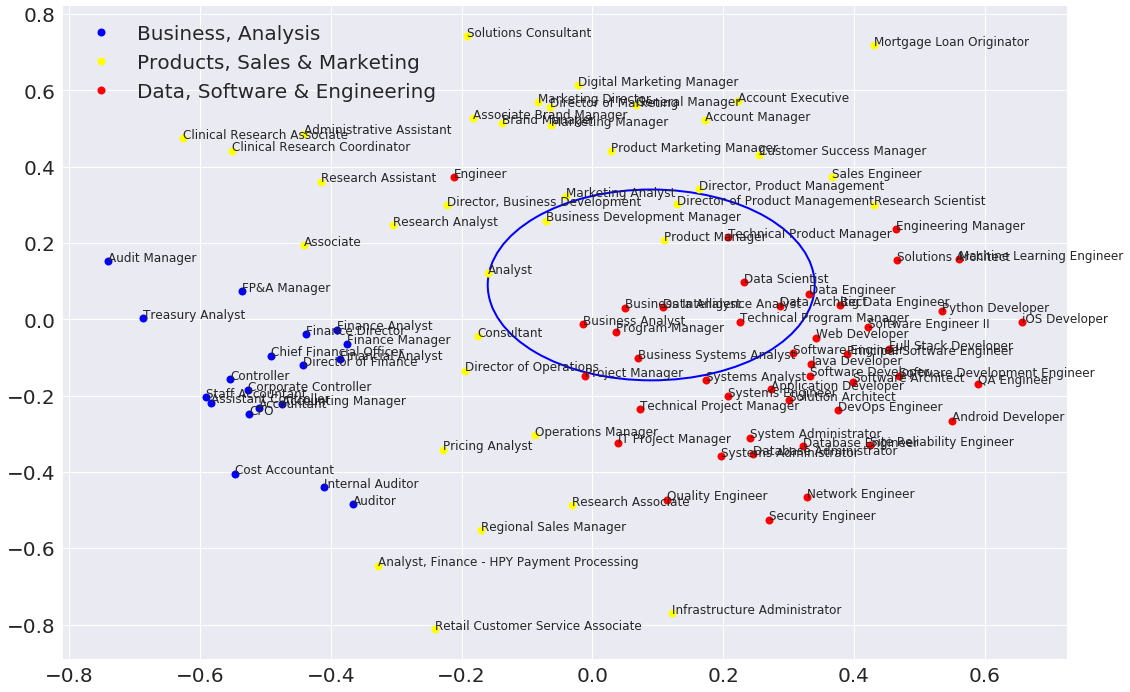

In [166]:
fig, ax = plt.subplots(figsize=(18, 12))

ax.margins(0.05)
for name, group in clusters:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=8, 
            label=cluster_names[name], color=cluster_colors[name])
    
ax.legend(numpoints=1)  
for idx, row in mds_df.iterrows():
    ax.text(row['x'],row['y'],
           row['job_titles'],size=12)
    
circle2 = plt.Circle((0.09, 0.09), 0.25, color='blue',fill=False,linewidth=2)
ax.add_artist(circle2)


    
plt.show()

## Exploring our Niche Jobs

It certainly seems like some of most homogeneous jobs between our Data Science and MBA categories include Project Manager, Product Manager, Program Manager and Business Analyst.

**Project Managers** plan, budget, document and execute specific projects undertaken by firms.  This requires coordinating with different parts of the business as well as upper management to ensure that investment in said project yields successful results.

**Product Managers** develop products by finding product-market fit, researching product requirements, creating timetables as well as pricing and marketing plans.

**Program Managers** develop action plans and teams to carry out project guidelines and requirements across different areas.  This role is actively involved in forecasting and budgeting.

**Business Analysts** coordinate between business and technical teams to ensure that business requirements and technical requirements are understood and met.

Most of these jobs deal with IT, which is probably a large reason they appear similar to Data Science roles.  There are also varying levels of managerial seniority amongst these jobs.  Business Analysts typically report to Project Managers, who in turn report to Program Managers.  The implicit seniority of the Product Manager role is a bit less apparent, however. 

Can we get any more insight behind these commonly misclassified, possibly dual category, jobs?
Lets look at some of the top attributes of each.

In [215]:
counter = 0
for idx, word in keywords.iterrows():
    test = word["jobtitle_count"]
    # if our top titles are in the titles count
    if "Product Manag" in test \
    or "Project Manag" in test \
    or "Program Manag" in test \
    or "Business Analyst" in test:    
    
        counter = counter+1
        keys = list(test.keys())
        vals = list(test.values())
        df = pd.DataFrame({"keys":keys,"vals":vals},columns=["keys","vals"])
        df["word"] = word[0]
        if counter == 1:
            df_all = df
        else:
            df_all = pd.concat([df_all,df])  

df_all = df_all[~\
    df_all['word'].isin(["c","nt","ant","ide","com","gis",
                        "design","format","tools","training",
                         "idea","forms","collaboration",
                         "partnership","air","provider",
                         " net","git","career","trust"])]

In [216]:
#keywords
keywords_proj_mgr = df_all[df_all['keys'].str.contains("Project Manag")]
keywords_proj_mgr = keywords_proj_mgr.groupby(["word"]).agg(\
    {"vals":"sum"}).sort_values(by="vals",ascending=False).head(20)
keywords_proj_mgr.reset_index(inplace=True)

keywords_prog_mgr = df_all[df_all['keys'].str.contains("Program Manag")]
keywords_prog_mgr = keywords_prog_mgr.groupby(["word"]).agg(\
    {"vals":"sum"}).sort_values(by="vals",ascending=False).head(20)
keywords_prog_mgr.reset_index(inplace=True)

keywords_bus_analyst = df_all[df_all['keys'].str.contains("Business Analyst")]
keywords_bus_analyst = keywords_bus_analyst.groupby(["word"]).agg(\
    {"vals":"sum"}).sort_values(by="vals",ascending=False).head(20)
keywords_bus_analyst.reset_index(inplace=True)

keywords_prod_mgr = df_all[df_all['keys'].str.contains("Product Manag")]
keywords_prod_mgr = keywords_prod_mgr.groupby(["word"]).agg(\
    {"vals":"sum"}).sort_values(by="vals",ascending=False).head(20)
keywords_prod_mgr.reset_index(inplace=True)

#degrees
degrees_proj_mgr = df_combined_clean2[df_combined_clean2['Job_Title'].str.contains(\
                 "Project Manag")].groupby("degree").size().sort_values(ascending=False).reset_index()
degrees_proj_mgr = degrees_proj_mgr[degrees_proj_mgr["degree"]!=""].head(20)

degrees_prog_mgr = df_combined_clean2[df_combined_clean2['Job_Title'].str.contains(\
                 "Program Manag")].groupby("degree").size().sort_values(ascending=False).reset_index()
degrees_prog_mgr = degrees_prog_mgr[degrees_prog_mgr["degree"]!=""].head(20)

degrees_bus_analyst = df_combined_clean2[df_combined_clean2['Job_Title'].str.contains(\
                 "Business Analyst")].groupby("degree").size().sort_values(ascending=False).reset_index()
degrees_bus_analyst = degrees_bus_analyst[degrees_bus_analyst["degree"]!=""].head(20)

degrees_prod_mgr = df_combined_clean2[df_combined_clean2['Job_Title'].str.contains(\
                 "Product Manag")].groupby("degree").size().sort_values(ascending=False).reset_index()
degrees_prod_mgr = degrees_prod_mgr[degrees_prod_mgr["degree"]!=""].head(20)

In [217]:
#companies
companies_proj_mgr = df_combined_clean[df_combined_clean['Job_Title'].str.contains(\
                 "Project Manag")].groupby("Company").size().sort_values(ascending=False).reset_index()
companies_proj_mgr = companies_proj_mgr[companies_proj_mgr["Company"]!=""].head(20)

companies_prog_mgr = df_combined_clean[df_combined_clean['Job_Title'].str.contains(\
                 "Program Manag")].groupby("Company").size().sort_values(ascending=False).reset_index()
companies_prog_mgr = companies_prog_mgr[companies_prog_mgr["Company"]!=""].head(20)

companies_bus_analyst = df_combined_clean[df_combined_clean['Job_Title'].str.contains(\
                 "Business Analyst")].groupby("Company").size().sort_values(ascending=False).reset_index()
companies_bus_analyst = companies_bus_analyst[companies_bus_analyst["Company"]!=""].head(20)

companies_prod_mgr = df_combined_clean[df_combined_clean['Job_Title'].str.contains(\
                 "Product Manag")].groupby("Company").size().sort_values(ascending=False).reset_index()
companies_prod_mgr = companies_prod_mgr[companies_prod_mgr["Company"]!=""].head(20)


In [218]:
#locations
locations_proj_mgr = df_combined_clean[df_combined_clean['Job_Title'].str.contains(\
                 "Project Manag")].groupby("Location").size().sort_values(ascending=False).reset_index()
locations_proj_mgr = locations_proj_mgr[locations_proj_mgr["Location"]!=""].head(20)

locations_prog_mgr = df_combined_clean[df_combined_clean['Job_Title'].str.contains(\
                 "Program Manag")].groupby("Location").size().sort_values(ascending=False).reset_index()
locations_prog_mgr = locations_prog_mgr[locations_prog_mgr["Location"]!=""].head(20)

locations_bus_analyst = df_combined_clean[df_combined_clean['Job_Title'].str.contains(\
                 "Business Analyst")].groupby("Location").size().sort_values(ascending=False).reset_index()
locations_bus_analyst = locations_bus_analyst[locations_bus_analyst["Location"]!=""].head(20)

locations_prod_mgr = df_combined_clean[df_combined_clean['Job_Title'].str.contains(\
                 "Product Manag")].groupby("Location").size().sort_values(ascending=False).reset_index()
locations_prod_mgr = locations_prod_mgr[locations_prod_mgr["Location"]!=""].head(20)


### Category Ratio

Overall we have a little over 8K jobs in our dataset amongst these 4 positions with the heaviest concentration belonging to Product Manager.

In [241]:
tot = len(df_combined_clean[df_combined_clean['Job_Title'].str.contains("Project Manag")])
n_mba = len(df_combined_clean[(df_combined_clean['Job_Title'].str.contains("Project Manag")) & \
                 (df_combined_clean['category']=="mba")])
print("Project Manager Job Counts: "+str(tot)+", MBA %: "+str(round(100*(n_mba/tot),2)))

tot = len(df_combined_clean[df_combined_clean['Job_Title'].str.contains("Program Manag")])
n_mba = len(df_combined_clean[(df_combined_clean['Job_Title'].str.contains("Program Manag")) & \
                 (df_combined_clean['category']=="mba")])
print("Program Manager Job Counts: "+str(tot)+", MBA %: "+str(round(100*(n_mba/tot),2)))

tot = len(df_combined_clean[df_combined_clean['Job_Title'].str.contains("Business Analyst")])
n_mba = len(df_combined_clean[(df_combined_clean['Job_Title'].str.contains("Business Analyst")) & \
                 (df_combined_clean['category']=="mba")])
print("Business Analyst Job Counts: "+str(tot)+", MBA %: "+str(round(100*(n_mba/tot),2)))

tot = len(df_combined_clean[df_combined_clean['Job_Title'].str.contains("Product Manag")])
n_mba = len(df_combined_clean[(df_combined_clean['Job_Title'].str.contains("Product Manag")) & \
                 (df_combined_clean['category']=="mba")])
print("Product Manager Job Counts: "+str(tot)+", MBA %: "+str(round(100*(n_mba/tot),2)))

Project Manager Job Counts: 1953, MBA %: 69.23
Program Manager Job Counts: 1647, MBA %: 70.73
Business Analyst Job Counts: 1131, MBA %: 44.12
Product Manager Job Counts: 3427, MBA %: 84.1


### Top Keywords

The below table shows the top skill-specific keywords by job type. Some takeaways:

* Program Manager and Project Manger have "risk" in the top three words, reinforcing the implied seniority of these positions whereas this word appears significantly farther down in the other two.

* Software and data appear prominently for all position types.  

* Marketing is first for Product Managers, but among the top six for all positions.

* Math is second for Business Analysts and SQL is fourth.

* "Cloud" and "api" are heavily featured along with "investment" and "architecture"

These are all clearly very technical roles with an emphasis on business.

In [219]:
kw_comb = pd.concat([keywords_prog_mgr,keywords_proj_mgr,keywords_bus_analyst,keywords_prod_mgr],axis=1)
kw_comb.columns = ["Program Manager","count","Project Manager","count","Business Analyst","count","Product Manager","count"]
kw_comb

,Program Manager,count,Project Manager,count,Business Analyst,count,Product Manager,count
0,data,242,data,300,data,380,marketing,893
1,risk,167,risk,267,math,128,data,613
2,software,141,software,155,software,82,software,282
3,marketing,131,testing,90,sql,75,growth,184
4,math,71,project team,87,testing,68,api,139
5,table,51,marketing,86,marketing,65,math,125
6,architecture,49,table,73,documentation,57,risk,114
7,security,47,architecture,69,database,49,table,113
8,testing,46,documentation,62,risk,45,architecture,109
9,cloud,42,deployment,45,table,37,business plan,78


### Top Degrees

What types of degrees are most sought out for these roles? Computer Science appears at the top all positions, but Business is second for Business Analyst and Product Manager, ahead of Technical and Engineering and vice-versa for the other two roles.  

Again, we see that the types of degrees sought after for these jobs are highly technical.

In [214]:
deg_comb = pd.concat([degrees_prog_mgr,degrees_proj_mgr,degrees_bus_analyst,degrees_prod_mgr],axis=1)
deg_comb.columns = ["Program Manager","count","Project Manager","count","Business Analyst","count","Product Manager","count"]
deg_comb

,Program Manager,count,Project Manager,count,Business Analyst,count,Product Manager,count
0,computer,149,computer,121,computer,158,computer,284
1,engineering,86,technical,83,business,104,business,133
2,business,86,business,79,technical,26,engineering,96
3,technical,37,engineering,57,quantitative,17,technical,78
4,social,17,finance,18,engineering,12,marketing,41
5,life,10,information,13,finance,11,technology,34
6,supply,8,management,11,statistics,9,master,8
7,quantitative,7,marketing,11,information,9,electrical,7
8,industrial,5,accounting,10,management,6,quantitative,7
9,behavioral,5,project,10,technology,6,biology,7


### Top Companies

What companies are hiring for these roles?  

* Amazon is at or near the top for all roles except for Project Manager.
* Staffing and consulting firms like Telarix, Axelon and Michael Page appear near the top in most categories.
* Tech firms dominate the list for top hirers of Program Managers.
* Amazon has been hiring a ton of Product Managers!

In [220]:
comp_comb = pd.concat([companies_prog_mgr,companies_proj_mgr,companies_bus_analyst,companies_prod_mgr],axis=1)
comp_comb.columns = ["Program Manager","count","Project Manager","count","Business Analyst","count","Product Manager","count"]
comp_comb

,Program Manager,count,Project Manager,count,Business Analyst,count,Product Manager,count
0,Amazon Corporate LLC,219,Visa,18,Telarix,22,Amazon Corporate LLC,301
1,Microsoft,127,Axelon Services Corporation,18,Amazon Corporate LLC,21,"Amazon Web Services, Inc.",42
2,"Amazon Web Services, Inc.",31,JP Morgan Chase,16,Capgemini,21,"Anthem, Inc.",39
3,Oracle,27,"Epiq Systems, Inc.",14,Exelon,17,Michael Page US,37
4,Google,24,Princeton Information Ltd,12,JP Morgan Chase,11,Capital One,34
5,Facebook,17,Eliassen Group,11,Eliassen Group,11,BuzzHero,32
6,Medtronic,17,"TalentBurst, Inc.",10,SugarCRM,10,Oracle,32
7,Raytheon,16,Experis,10,Wells Fargo,9,JP Morgan Chase,31
8,"A2Z Development Center, Inc.",15,Edison International,10,Ellie Mae,9,Verizon,30
9,Vista Equity Partners,15,Kaiser Permanente,9,Ascent Services Group,9,Wells Fargo,20


### Top Cities

Unsuprisingly, it looks like the same top 5 or 6 cities dominate the landscape for these jobs.  Seattle and New York lead the way in all our categories. It seems like there is a high demand for Product Managers in many cities, especially Seattle, San Francisco, New York and Boston.

In [176]:
cities_comb = pd.concat([locations_prog_mgr,locations_proj_mgr,locations_bus_analyst,locations_prod_mgr],axis=1)
cities_comb.columns = ["Program Manager","count","Project Manager","count","Business Analyst","count","Product Manager","count"]
cities_comb

,Program Manager,count,Project Manager,count,Business Analyst,count,Product Manager,count
0,"Seattle, WA",291,"New York, NY",139,"New York, NY",84,"Seattle, WA",475
1,"Redmond, WA",123,"Boston, MA",71,"Atlanta, GA",57,"San Francisco, CA",426
2,"San Francisco, CA",89,"San Francisco, CA",71,"Seattle, WA",50,"New York, NY",204
3,"New York, NY",62,"Chicago, IL",69,"Boston, MA",39,"Boston, MA",106
4,"Chicago, IL",40,"Washington, DC",63,"Chicago, IL",37,"Chicago, IL",98
5,"Austin, TX",39,"Austin, TX",56,"Austin, TX",33,"Austin, TX",87
6,"Washington, DC",35,"Houston, TX",55,"San Francisco, CA",30,"San Jose, CA",74
7,"Mountain View, CA",35,"Seattle, WA",50,"Columbus, OH",26,"Atlanta, GA",60
8,"San Diego, CA",34,"Los Angeles, CA",46,"Houston, TX",25,"San Diego, CA",58
9,"San Jose, CA",33,"Atlanta, GA",45,"Vienna, VA",23,"San Mateo, CA",55


# Conclusion

We've come to the end of the analysis.  As a reminder, our goal when we set out was to explore the differences in job descriptions, companies, cities and titles between two distinct job types as categorized by Indeed.com: MBA and Data Scientist.  The technical aim was to see if we can apply Machine Learning to learn about these differences and effectively judge what type of category a given job description beloinged to.

The steps we took to accomplish this were:

* Explored top skill-specific keywords by category
* Explored top acedemic degree requirements by category
* Explored the geographic distribution of jobs in the data
* Explored the types of companies hiring for these roles
* Explored the mix of job titles in the data
* Trained classification models to classify job categories based on job description text.
* Explored most misclassified (homogeneous) types of jobs across each category and the details behind them.

# Computing Environment/Specs Used

#### Platform/OS

In [283]:
import platform
print("Platform:"+str(platform.system())+str(platform.architecture()))
print("..."+str(platform.release())+str(platform.version()))

Platform:Linux('64bit', '')
...4.10.0-35-generic#39-Ubuntu SMP Wed Sep 13 07:46:59 UTC 2017


#### Python Version

In [284]:
import sys
print("Python Version: "+str(sys.version))

Python Version: 3.5.3 (default, Jul 21 2017, 01:02:33) 
[GCC 6.3.0 20170406]


#### Packages/Libraries

In [285]:
import pandas as pd
print(pd.__name__," ",pd.__version__)

pandas   0.20.3


In [286]:
import nltk
print(nltk.__name__," ",nltk.__version__)

nltk   3.2.4


In [287]:
import numpy as np
print(np.__name__," ",np.__version__)

numpy   1.13.1


In [288]:
import re
print(re.__name__," ",re.__version__)

re   2.2.1


In [289]:
import sklearn
print(sklearn.__name__," ",sklearn.__version__)

sklearn   0.19.0


In [290]:
import matplotlib
print(matplotlib.__name__," ",matplotlib.__version__)

matplotlib   2.0.2


In [294]:
import seaborn as sns
print(sns.__name__," ",sns.__version__)

seaborn   0.8.0


In [291]:
import geopy
print(geopy.__name__," ",geopy.__version__)

geopy   1.11.0


In [292]:
import scipy
print(scipy.__name__," ",scipy.__version__)

scipy   0.19.1
